In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:21: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, OrderedDict, Sequence


In [2]:
df = pd.read_pickle('df_clean.pkl')
df.columns

Index(['rating', 'rating_title', 'rating_description', 'rating_pros',
       'rating_cons', 'no_contract', 'rating_description_list', 'tokenized',
       'lower', 'no_punc', 'stopwords_removed', 'pos_tags', 'wordnet_pos',
       'lemmatized'],
      dtype='object')

In [3]:
df = df[['rating', 'lemmatized']]
df

,rating,lemmatized
0,4,"[best, work, bad, position, perm, position, st..."
1,4,"[work, mdp, project, fun, co-worker, fun, easy..."
2,4,"[contractor, strict, schedule, divide, section..."
3,5,"[contract, amazing, experience, wonderful, com..."
4,1,"[condition, safe, management, joke, osha, call..."
5,3,"[best, work/life, balance, compensation, peopl..."
6,4,"[pro, stand, shoulder, giant, build, best, dev..."
7,5,"[excellent, internship, program, learn, best, ..."
8,4,"[lay, phone, rebrand, pixel, use, motorola, co..."
9,4,"[work, challenge, interesting, highly, recomme..."


### Sentiment Analysis
Sentiment analysis tries to determine the writer's attitude/option.  

In [4]:
df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

In [5]:
df

,rating,lemmatized,lemma_str
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...


In [6]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [7]:
df

,rating,lemmatized,lemma_str,sentiment
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...,0.368750
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...,0.333333
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...,0.142361
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...,0.600000
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...,0.500000
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...,0.296338
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...,0.188280
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...,0.712121
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...,0.700000
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...,0.386667


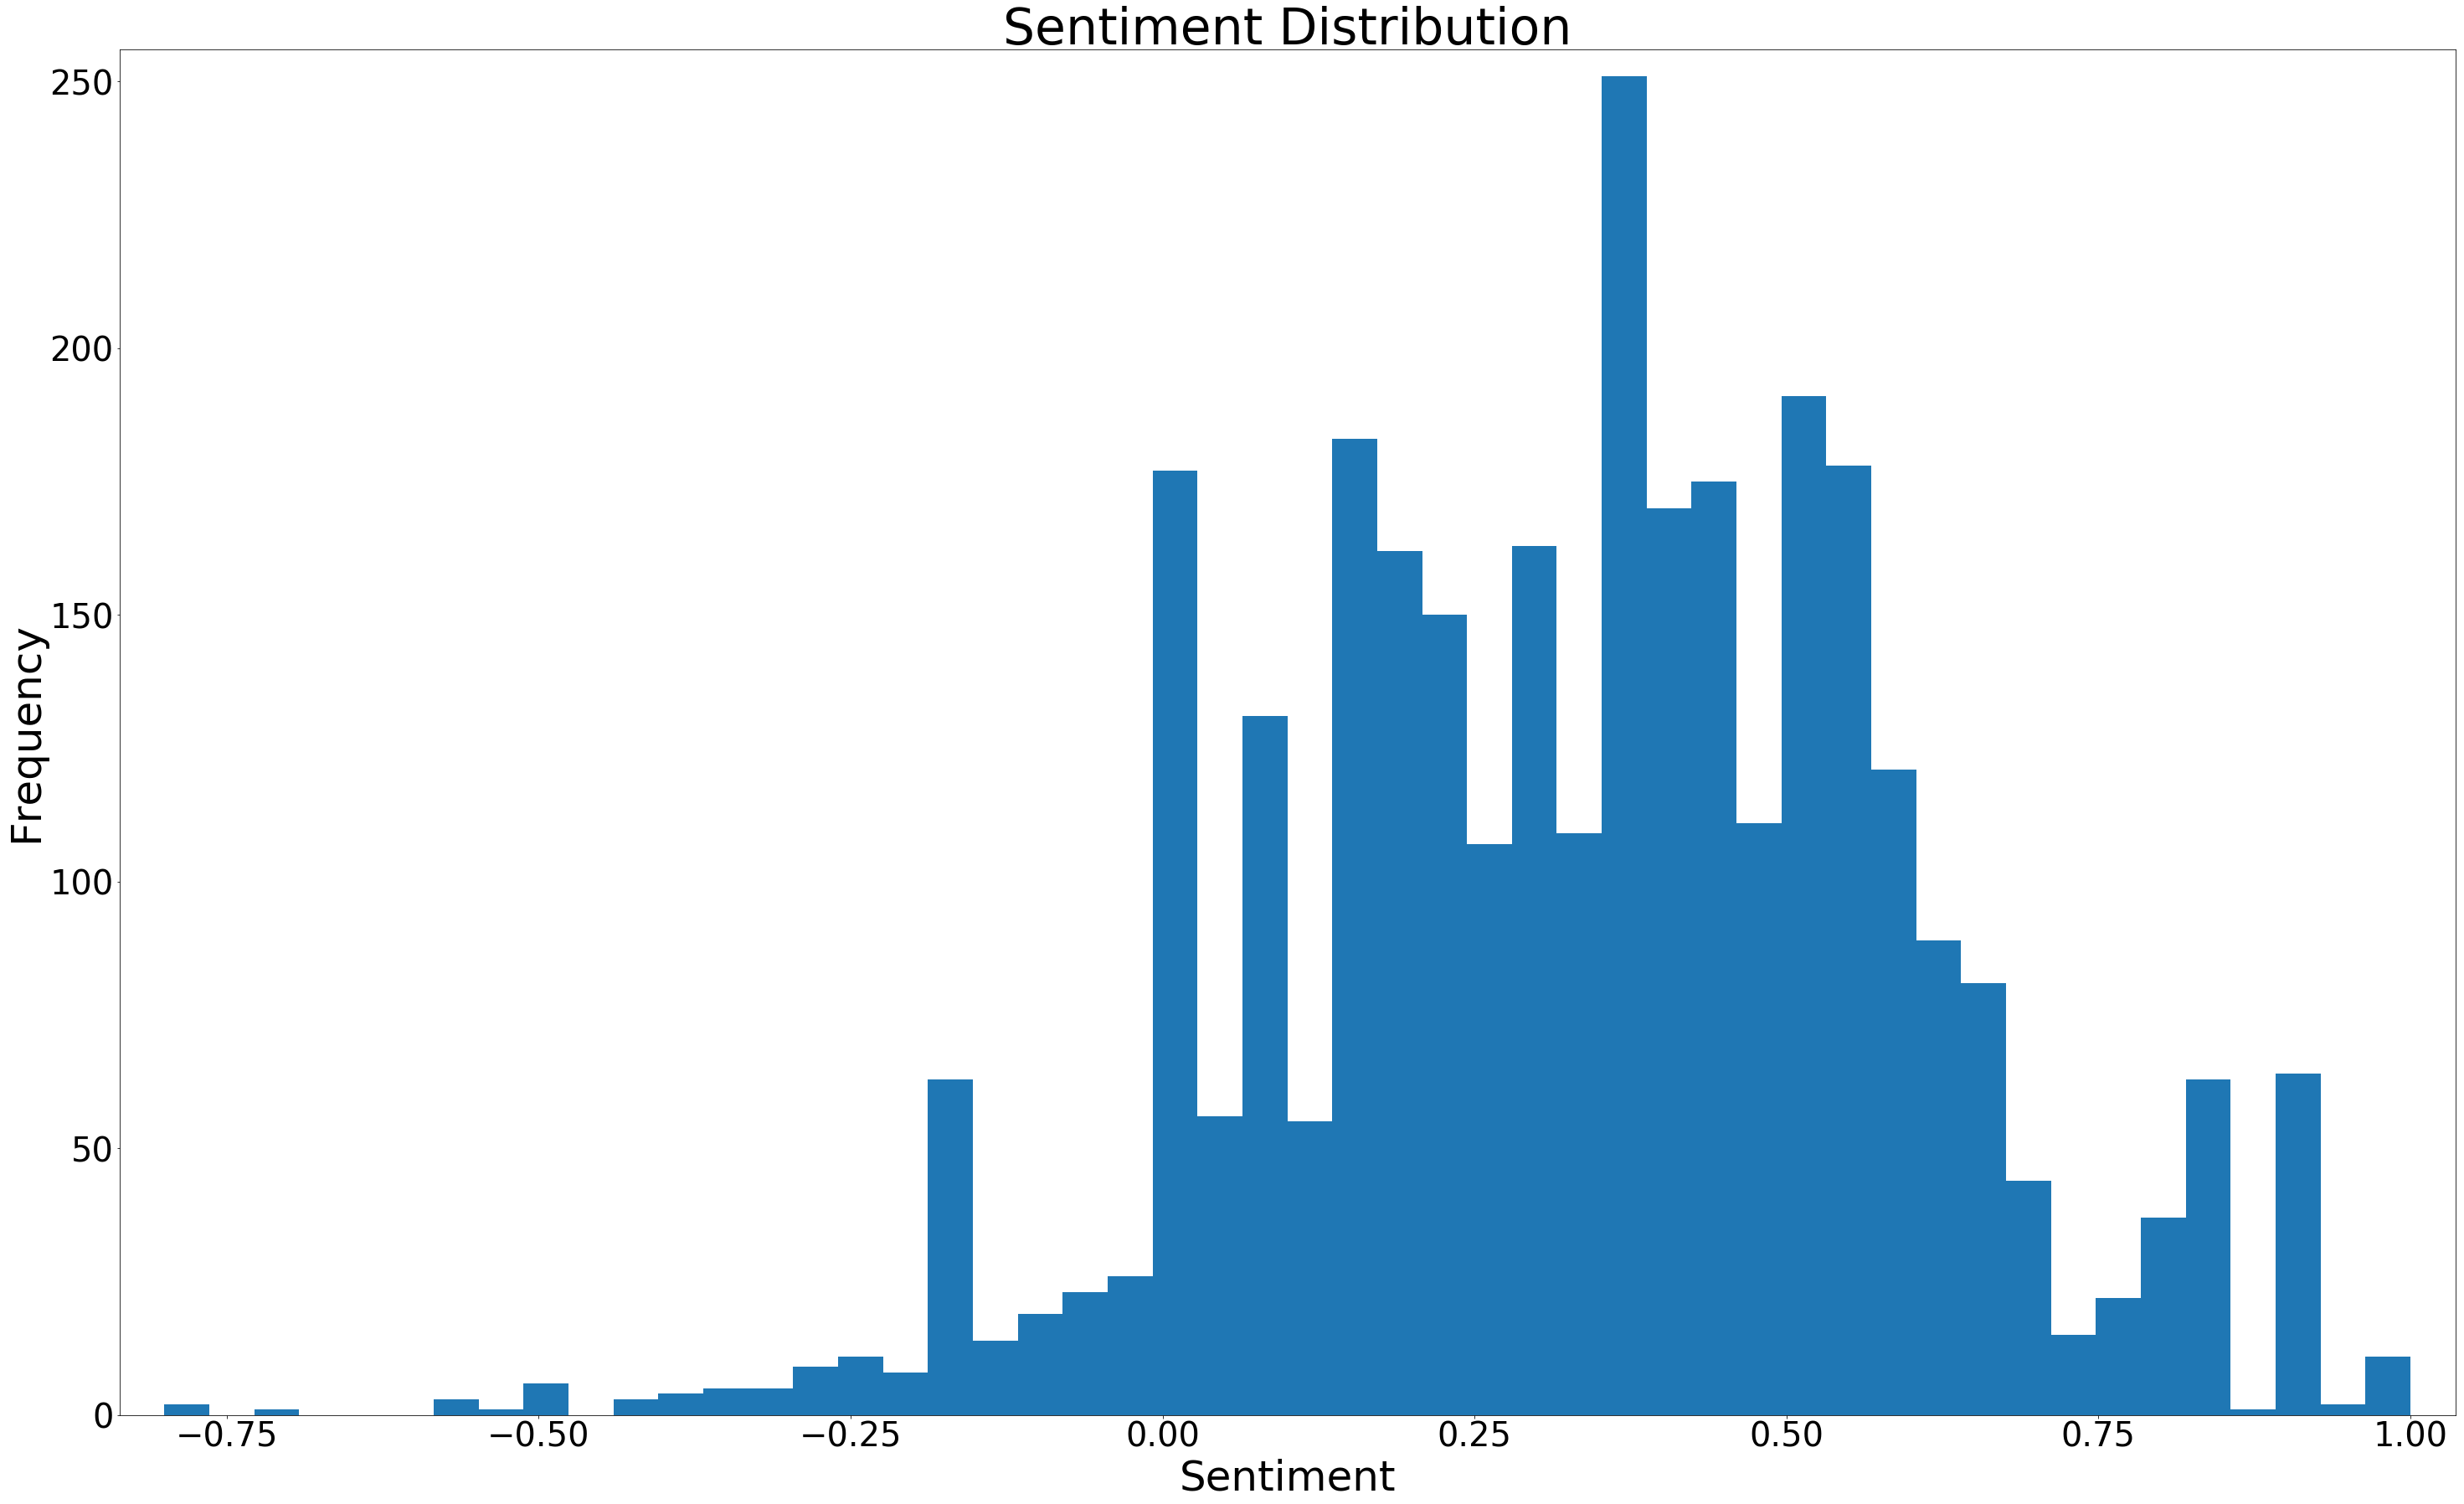

In [8]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

In [9]:
df.loc[df['rating']==1.0].describe()

,rating,sentiment
count,51.0,51.000000
mean,1.0,0.036674
std,0.0,0.302651
min,1.0,-0.575000
25%,1.0,-0.158333
50%,1.0,0.000000
75%,1.0,0.246591
max,1.0,0.700000


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

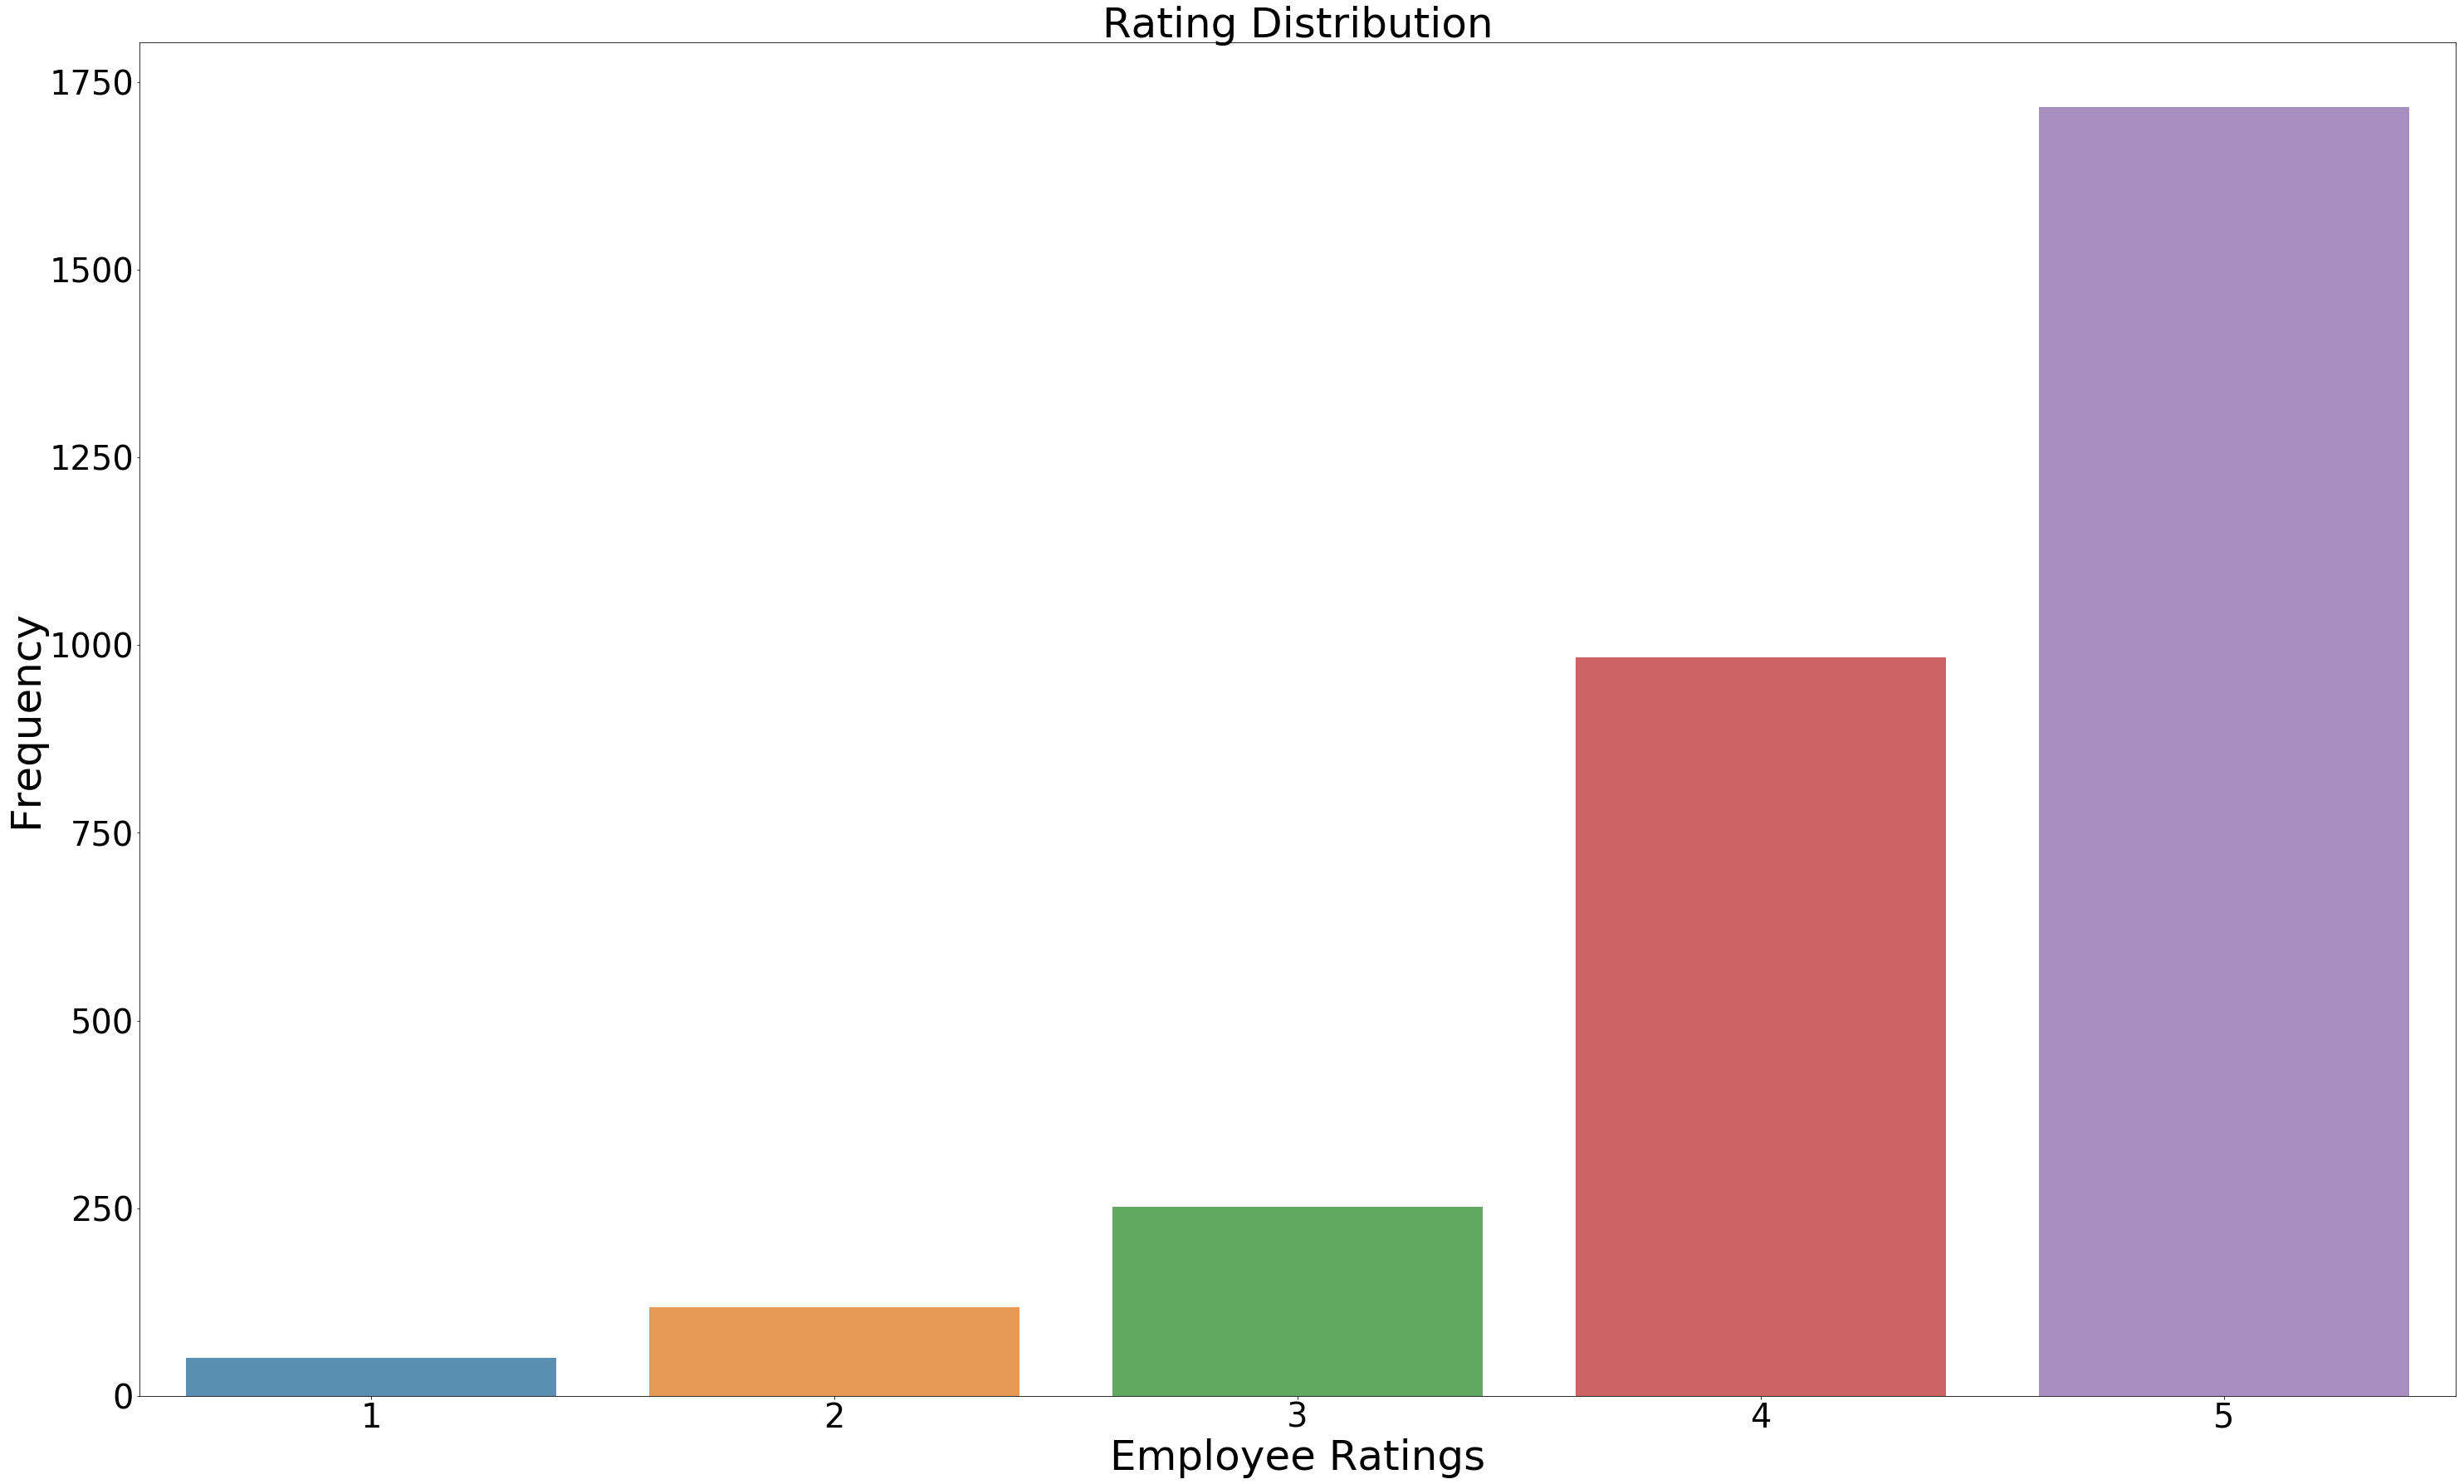

In [10]:
x_rating = df.rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Employee Ratings', fontsize=50)
plt.xticks(fontsize=40)

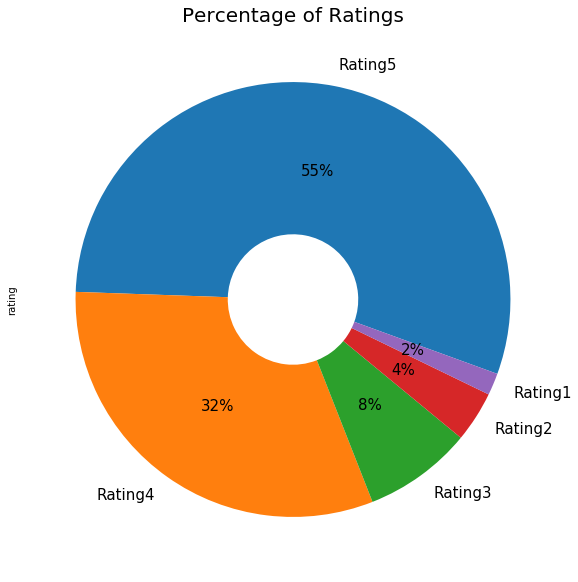

In [11]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
df.rating.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

The employee ratings and sentiment analysis seem to confirm each other as for the most part the majority of our reviews and ratings are positive.  Let's examine this a bit deeper using blxplots. 

In [12]:
y0 = df.loc[df['rating']==1.0]['sentiment']
y1 = df.loc[df['rating']==2.0]['sentiment']
y2 = df.loc[df['rating']==3.0]['sentiment']
y3 = df.loc[df['rating']==4.0]['sentiment']
y4 = df.loc[df['rating']==5.0]['sentiment']
boxplot_data = [y0, y1, y2, y3, y4]

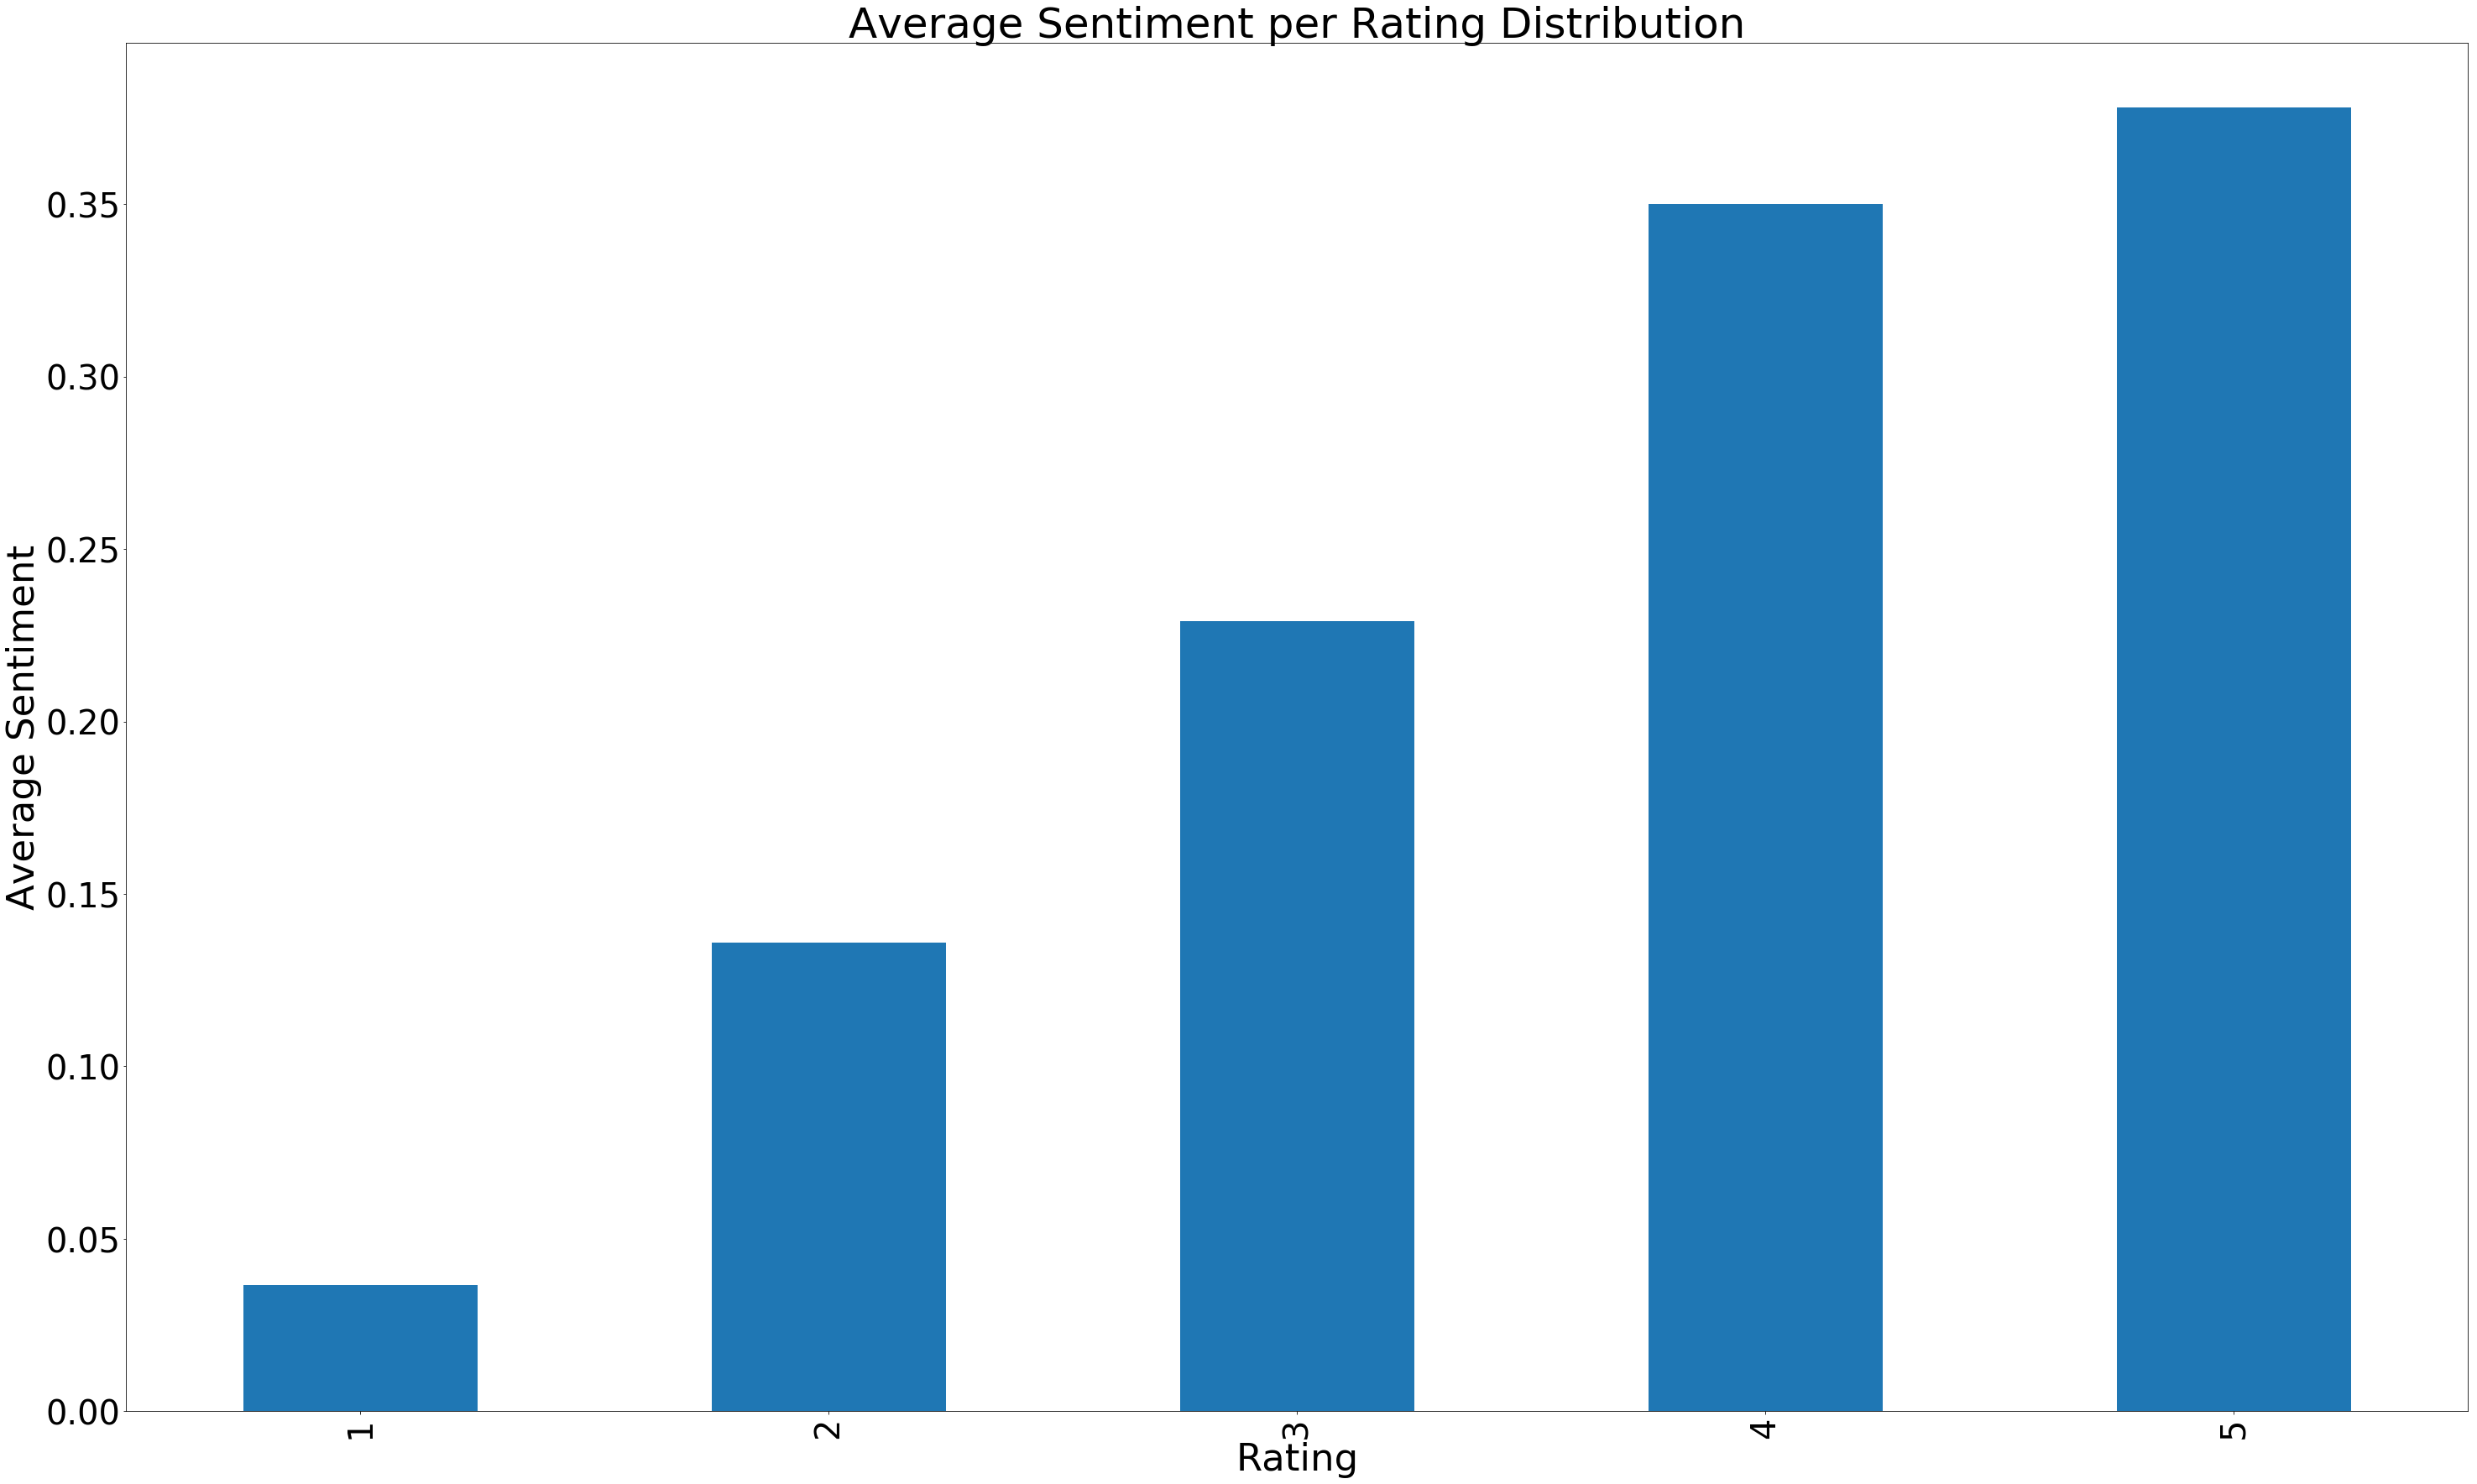

In [13]:
polarity_avg = df.groupby('rating')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

In [14]:
# create a new feature for length of the review
df['review_len'] = df['lemmatized'].astype(str).apply(len)


In [15]:
# Create a new feature for the word count fo the review
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))

In [16]:
df

,rating,lemmatized,lemma_str,sentiment,review_len,word_count
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...,0.368750,121,12
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...,0.333333,178,17
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...,0.142361,567,56
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...,0.600000,188,18
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...,0.500000,129,15
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...,0.296338,148,15
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...,0.188280,1064,102
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...,0.712121,216,20
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...,0.700000,99,11
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...,0.386667,141,13


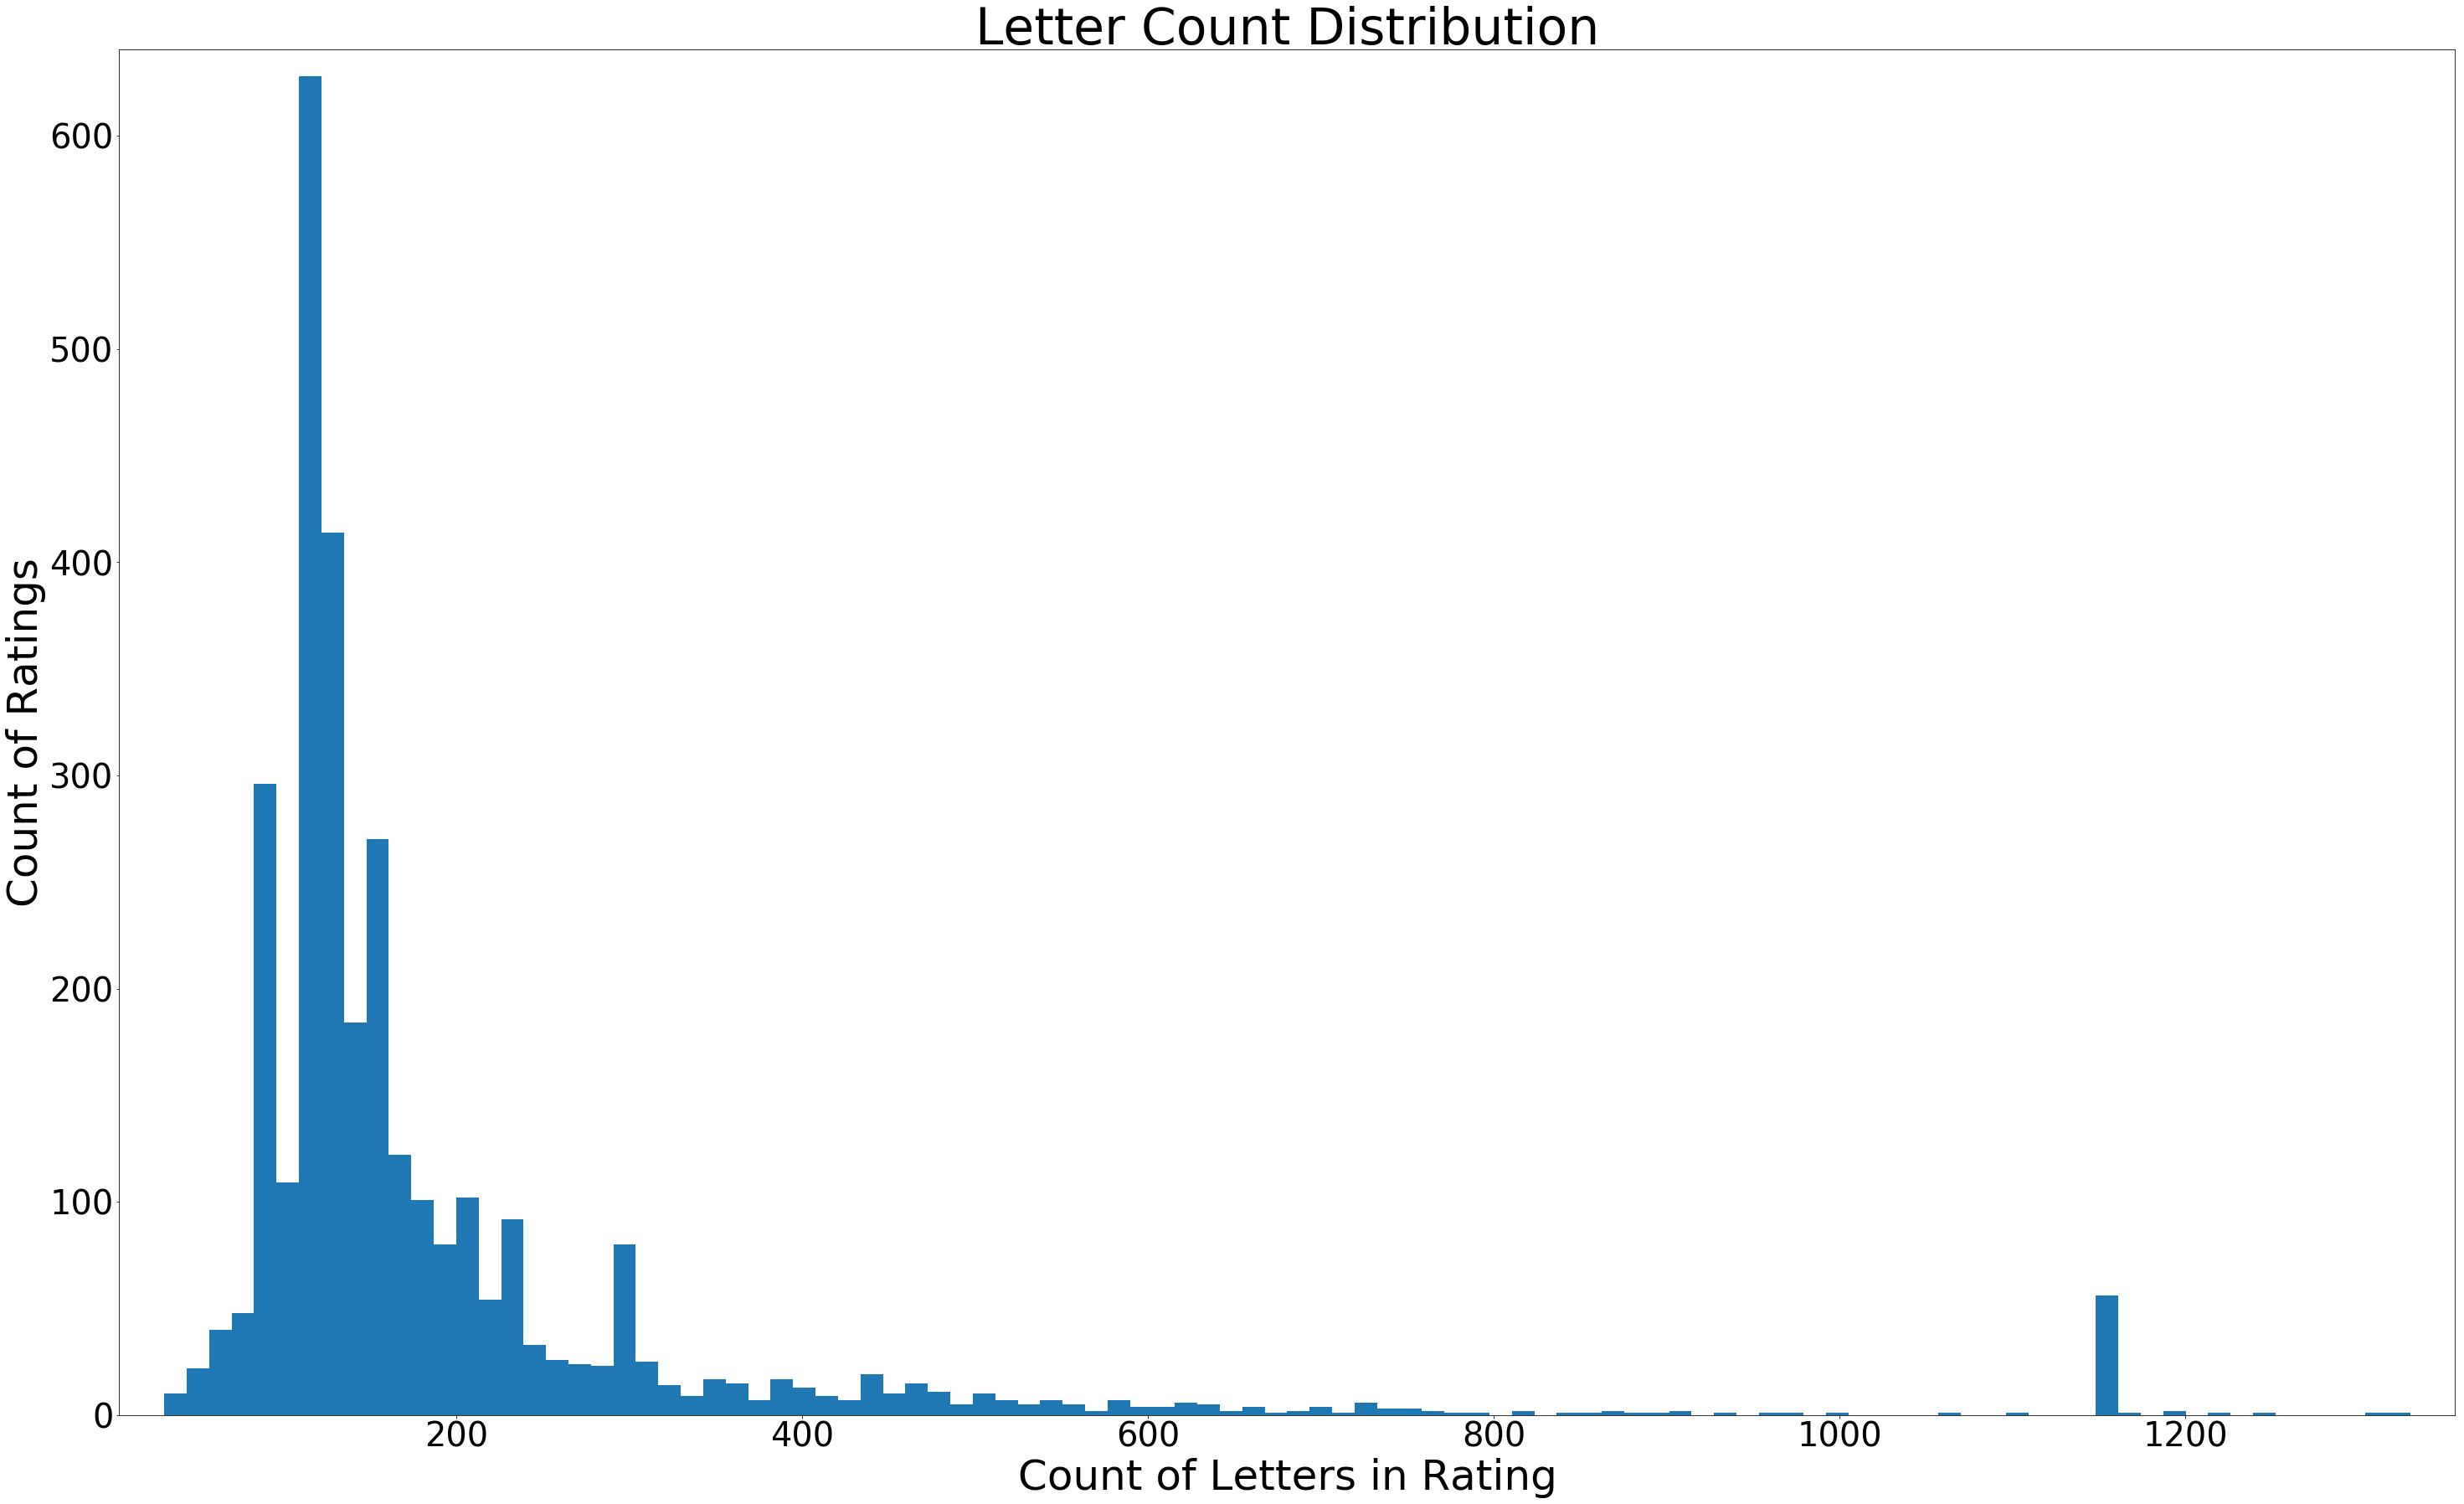

In [17]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Count of Letters in Rating', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Count of Ratings', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['review_len'], bins=100)
plt.title('Letter Count Distribution', fontsize=60)
plt.show()

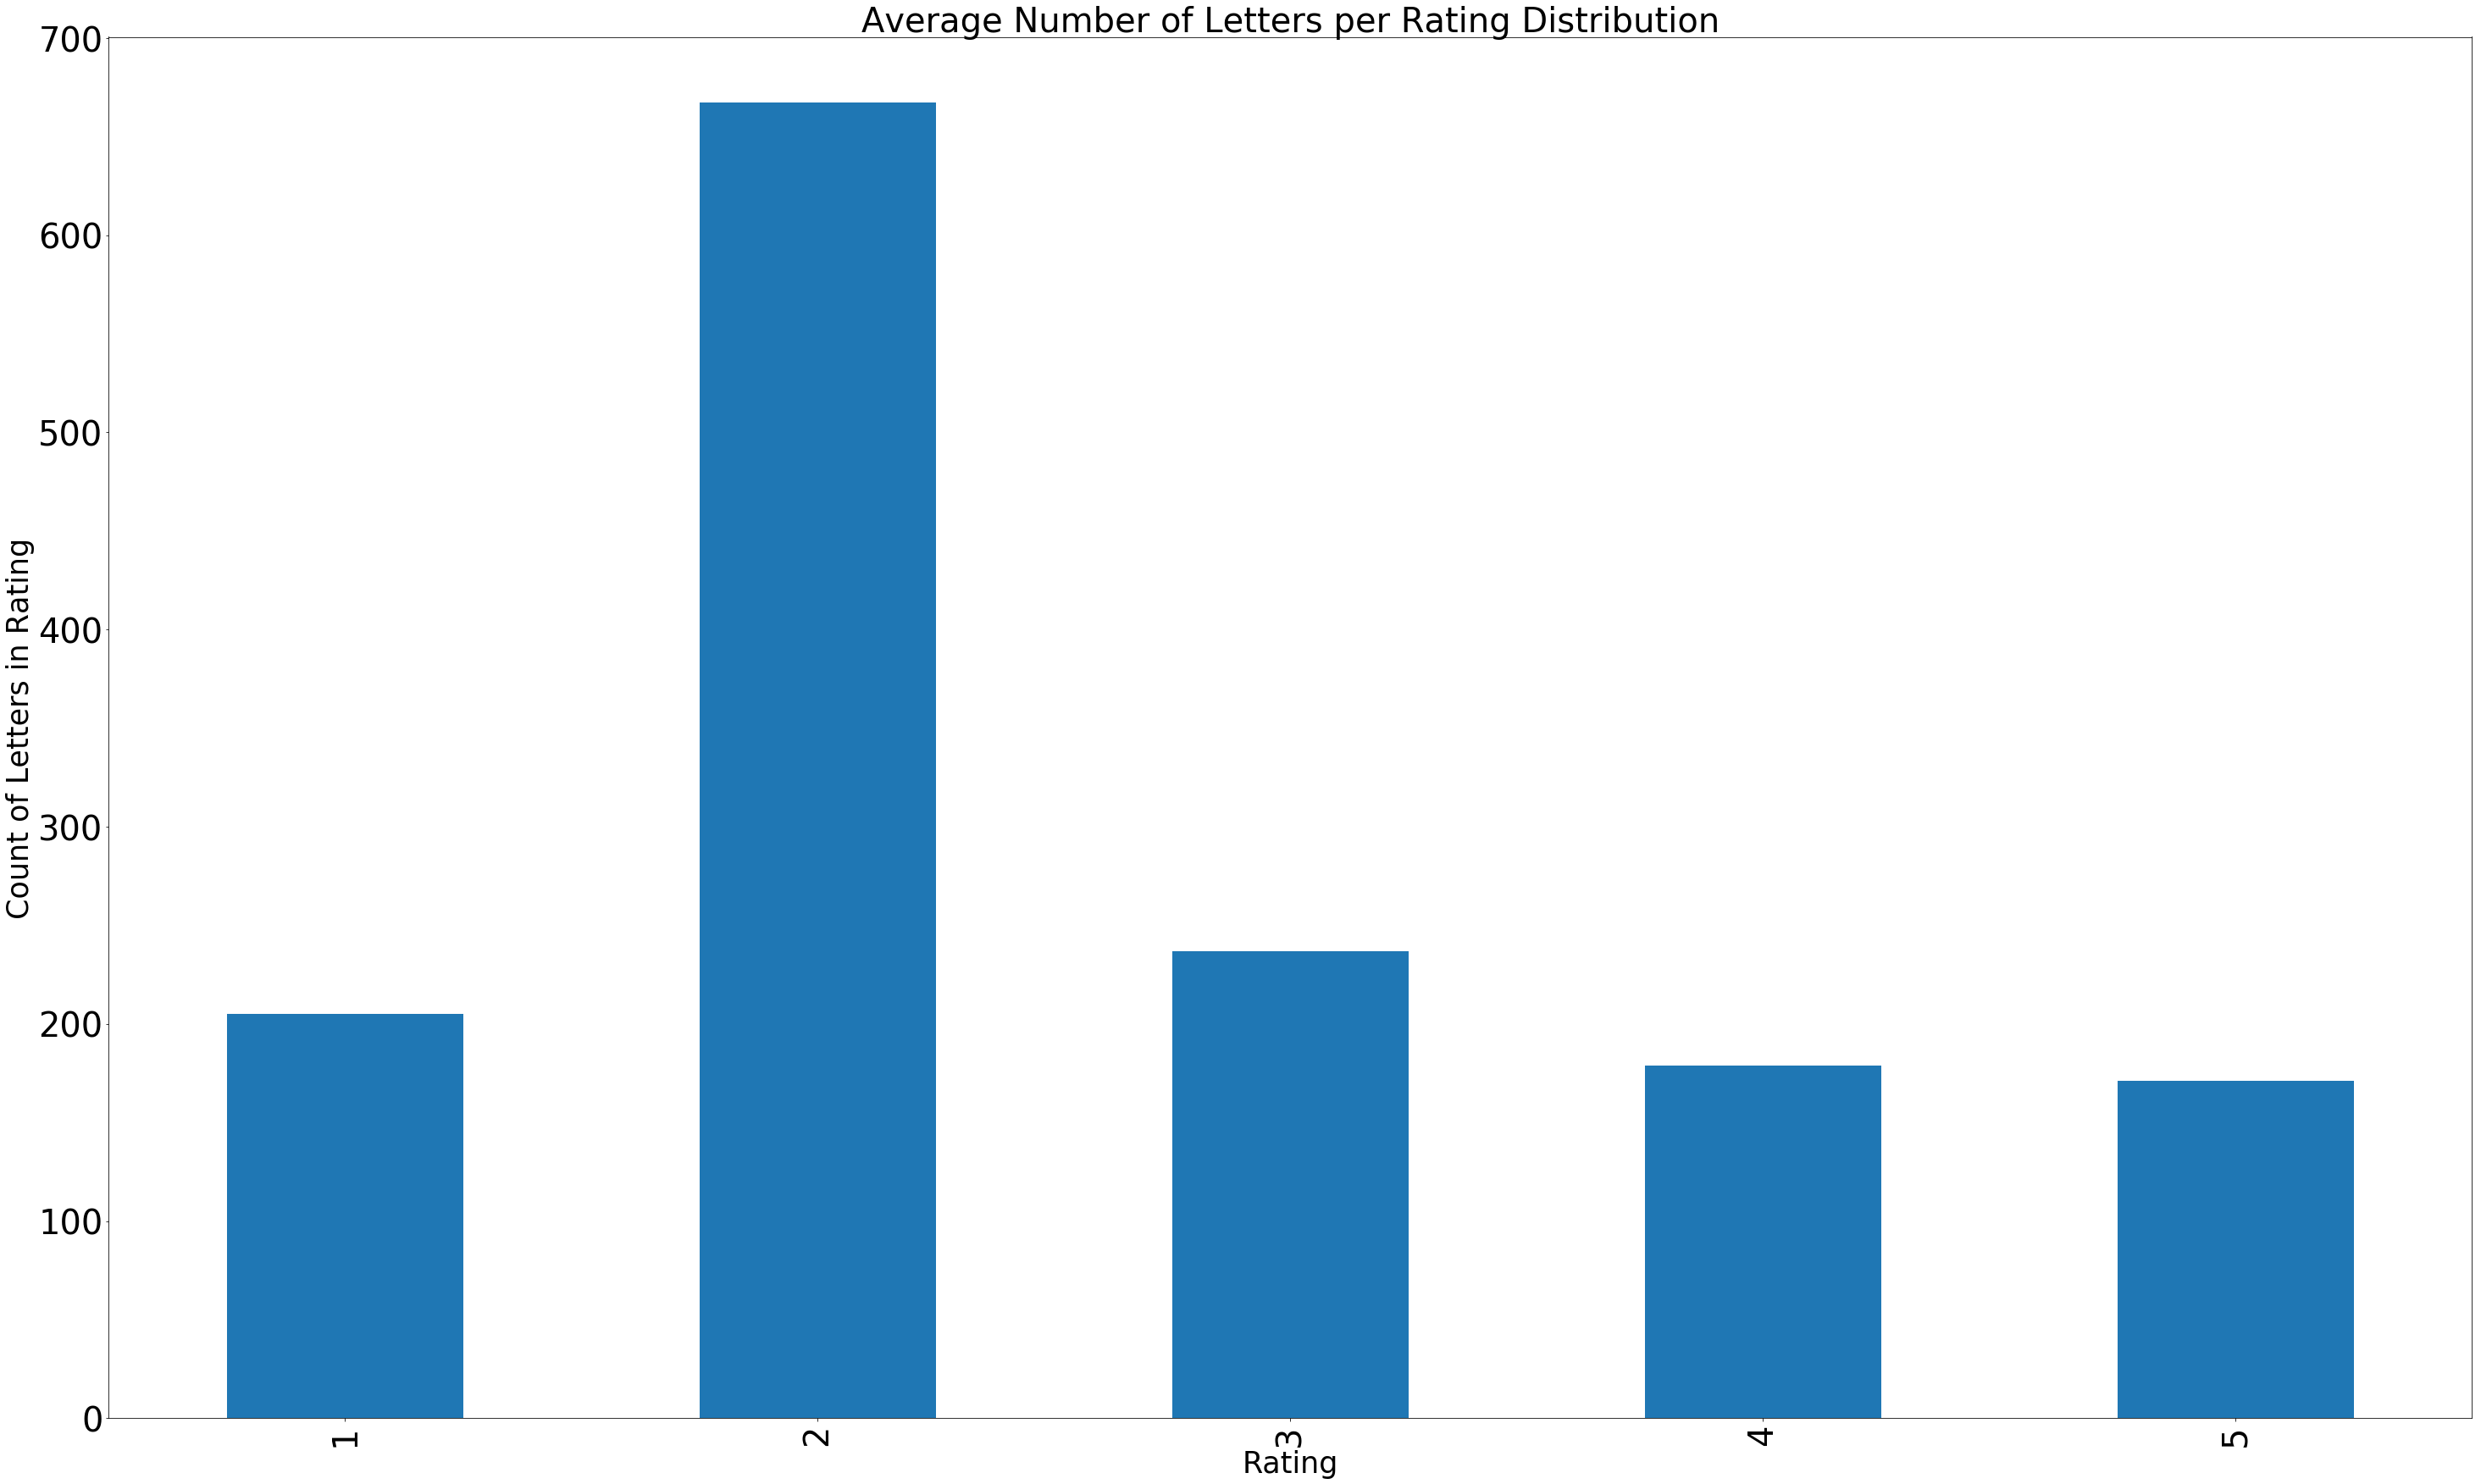

In [18]:
letter_avg = df.groupby('rating')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Rating Distribution', fontsize=40)
plt.show()

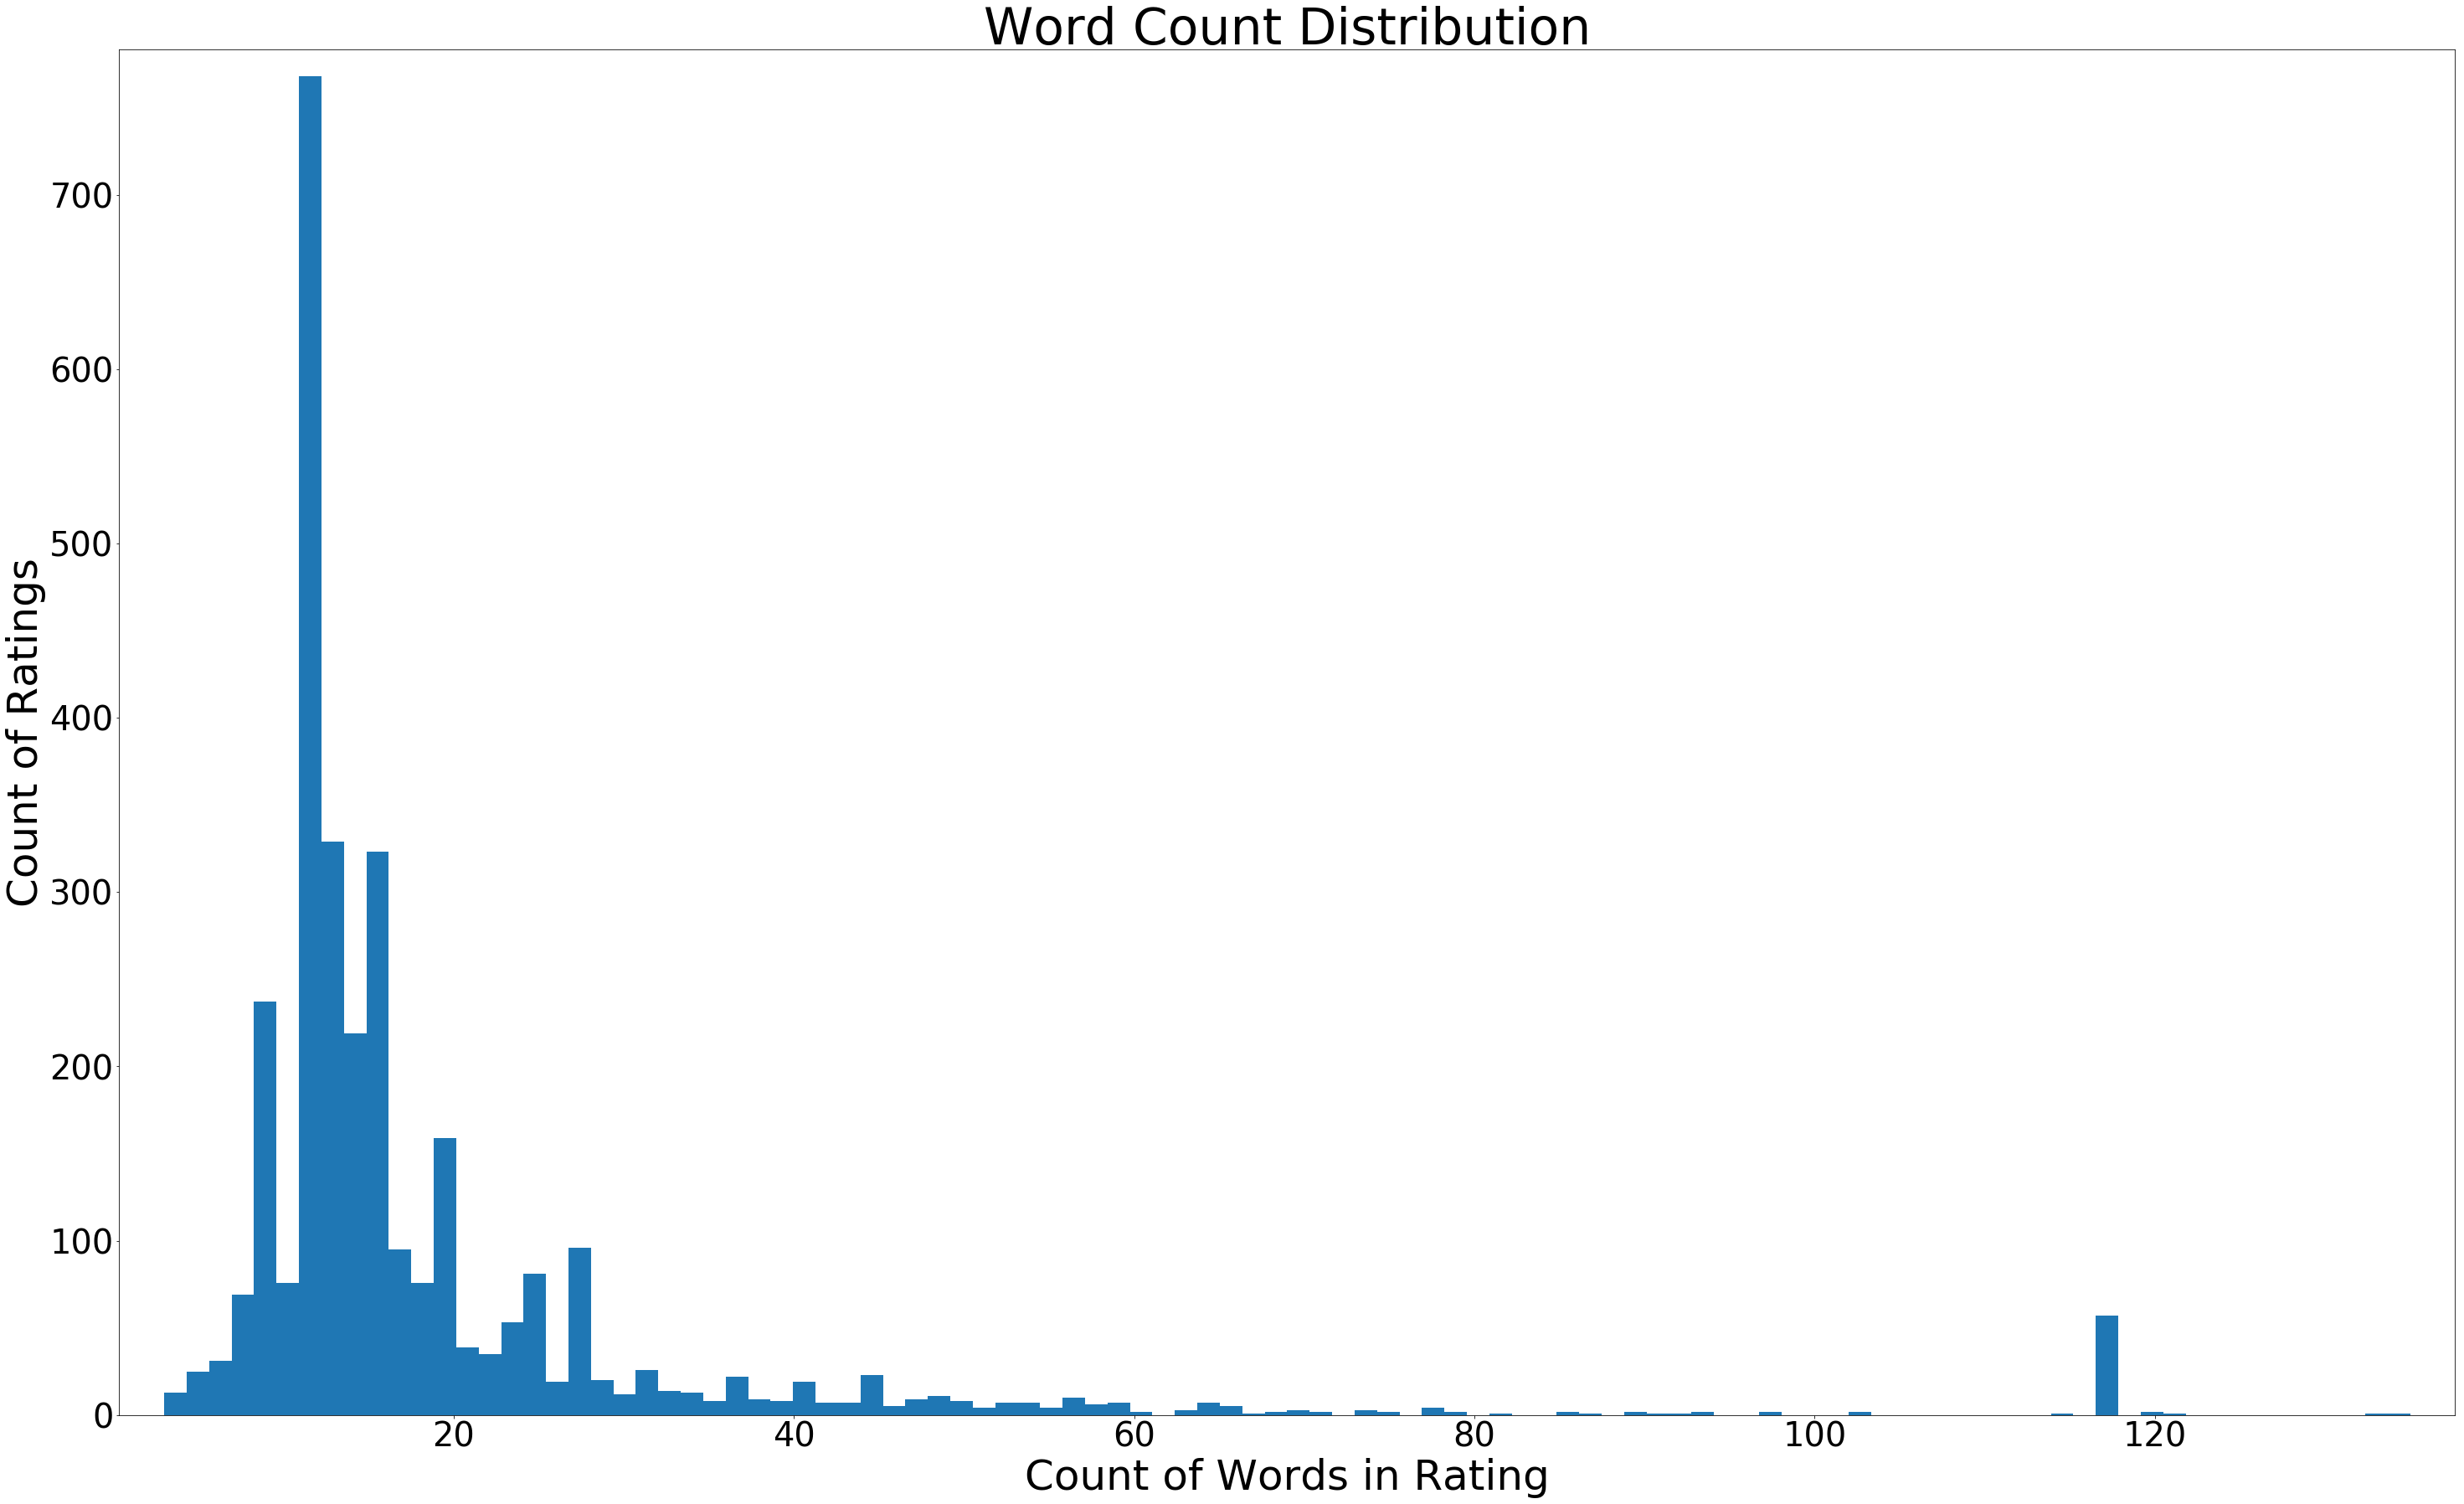

In [19]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Count of Words in Rating', fontsize=50)
plt.ylabel('Count of Ratings', fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.hist(df['word_count'], bins=100)
plt.title('Word Count Distribution', fontsize=60)
plt.show()

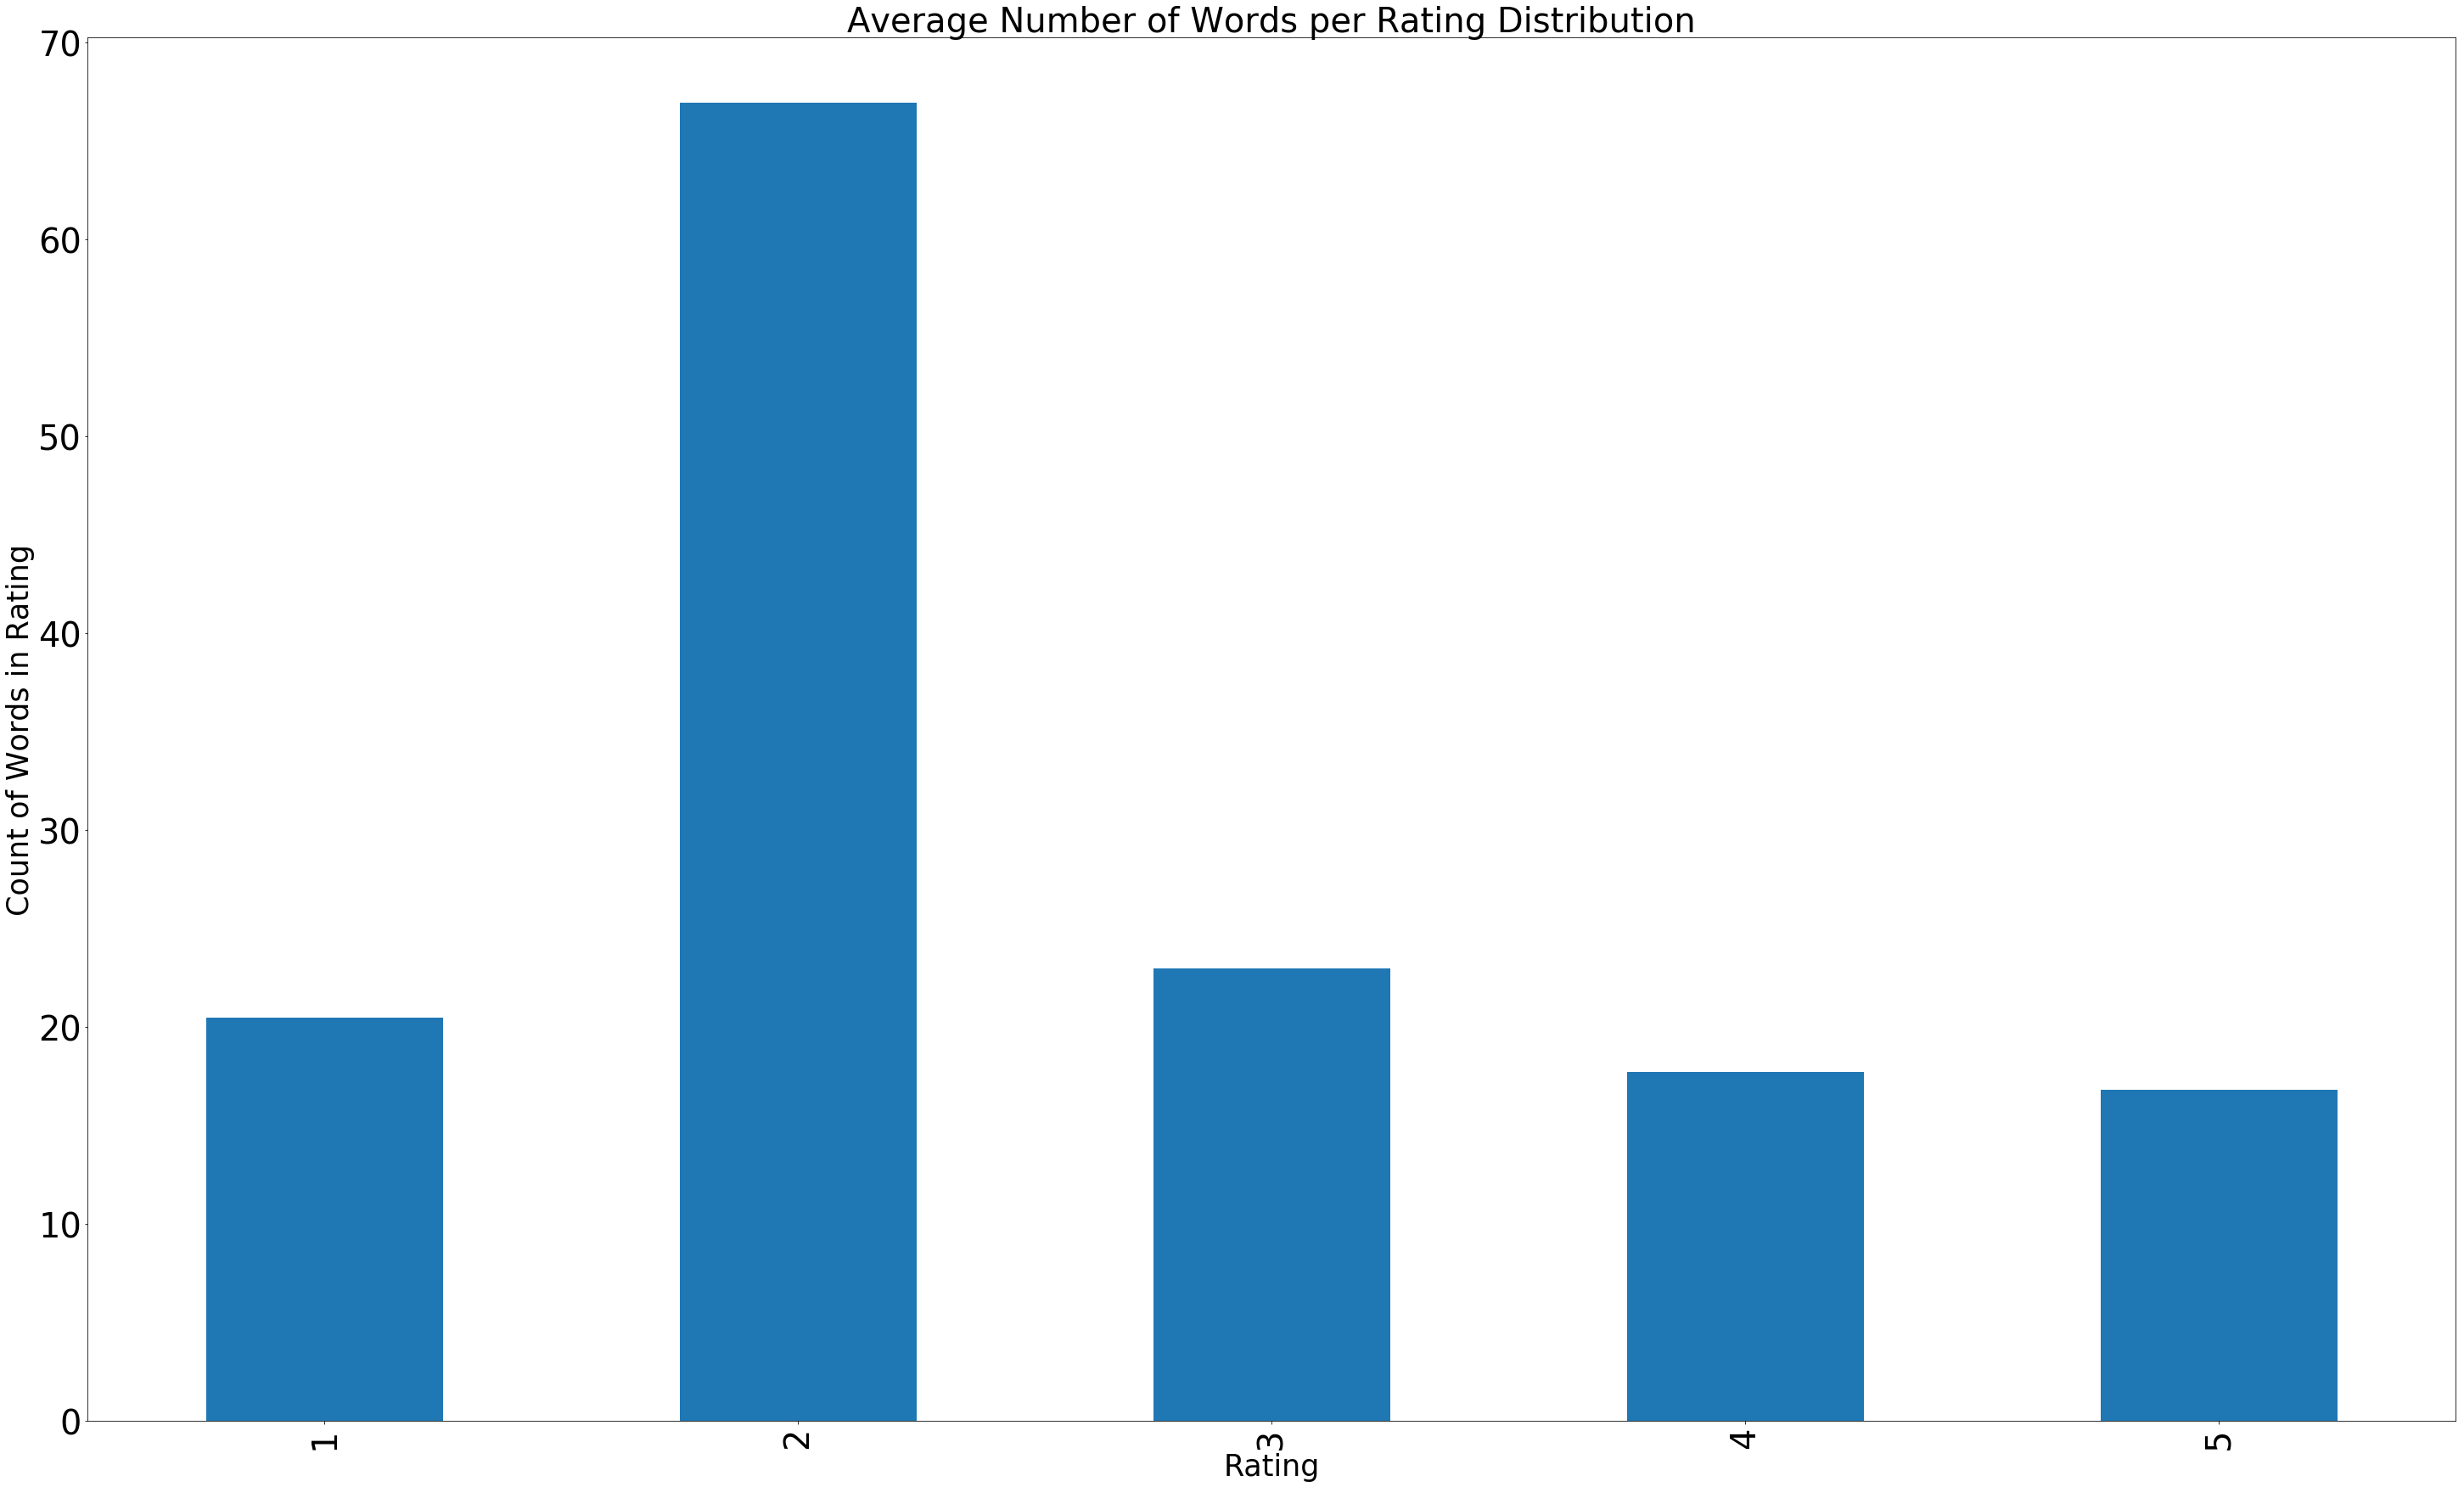

In [20]:
word_avg = df.groupby('rating')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

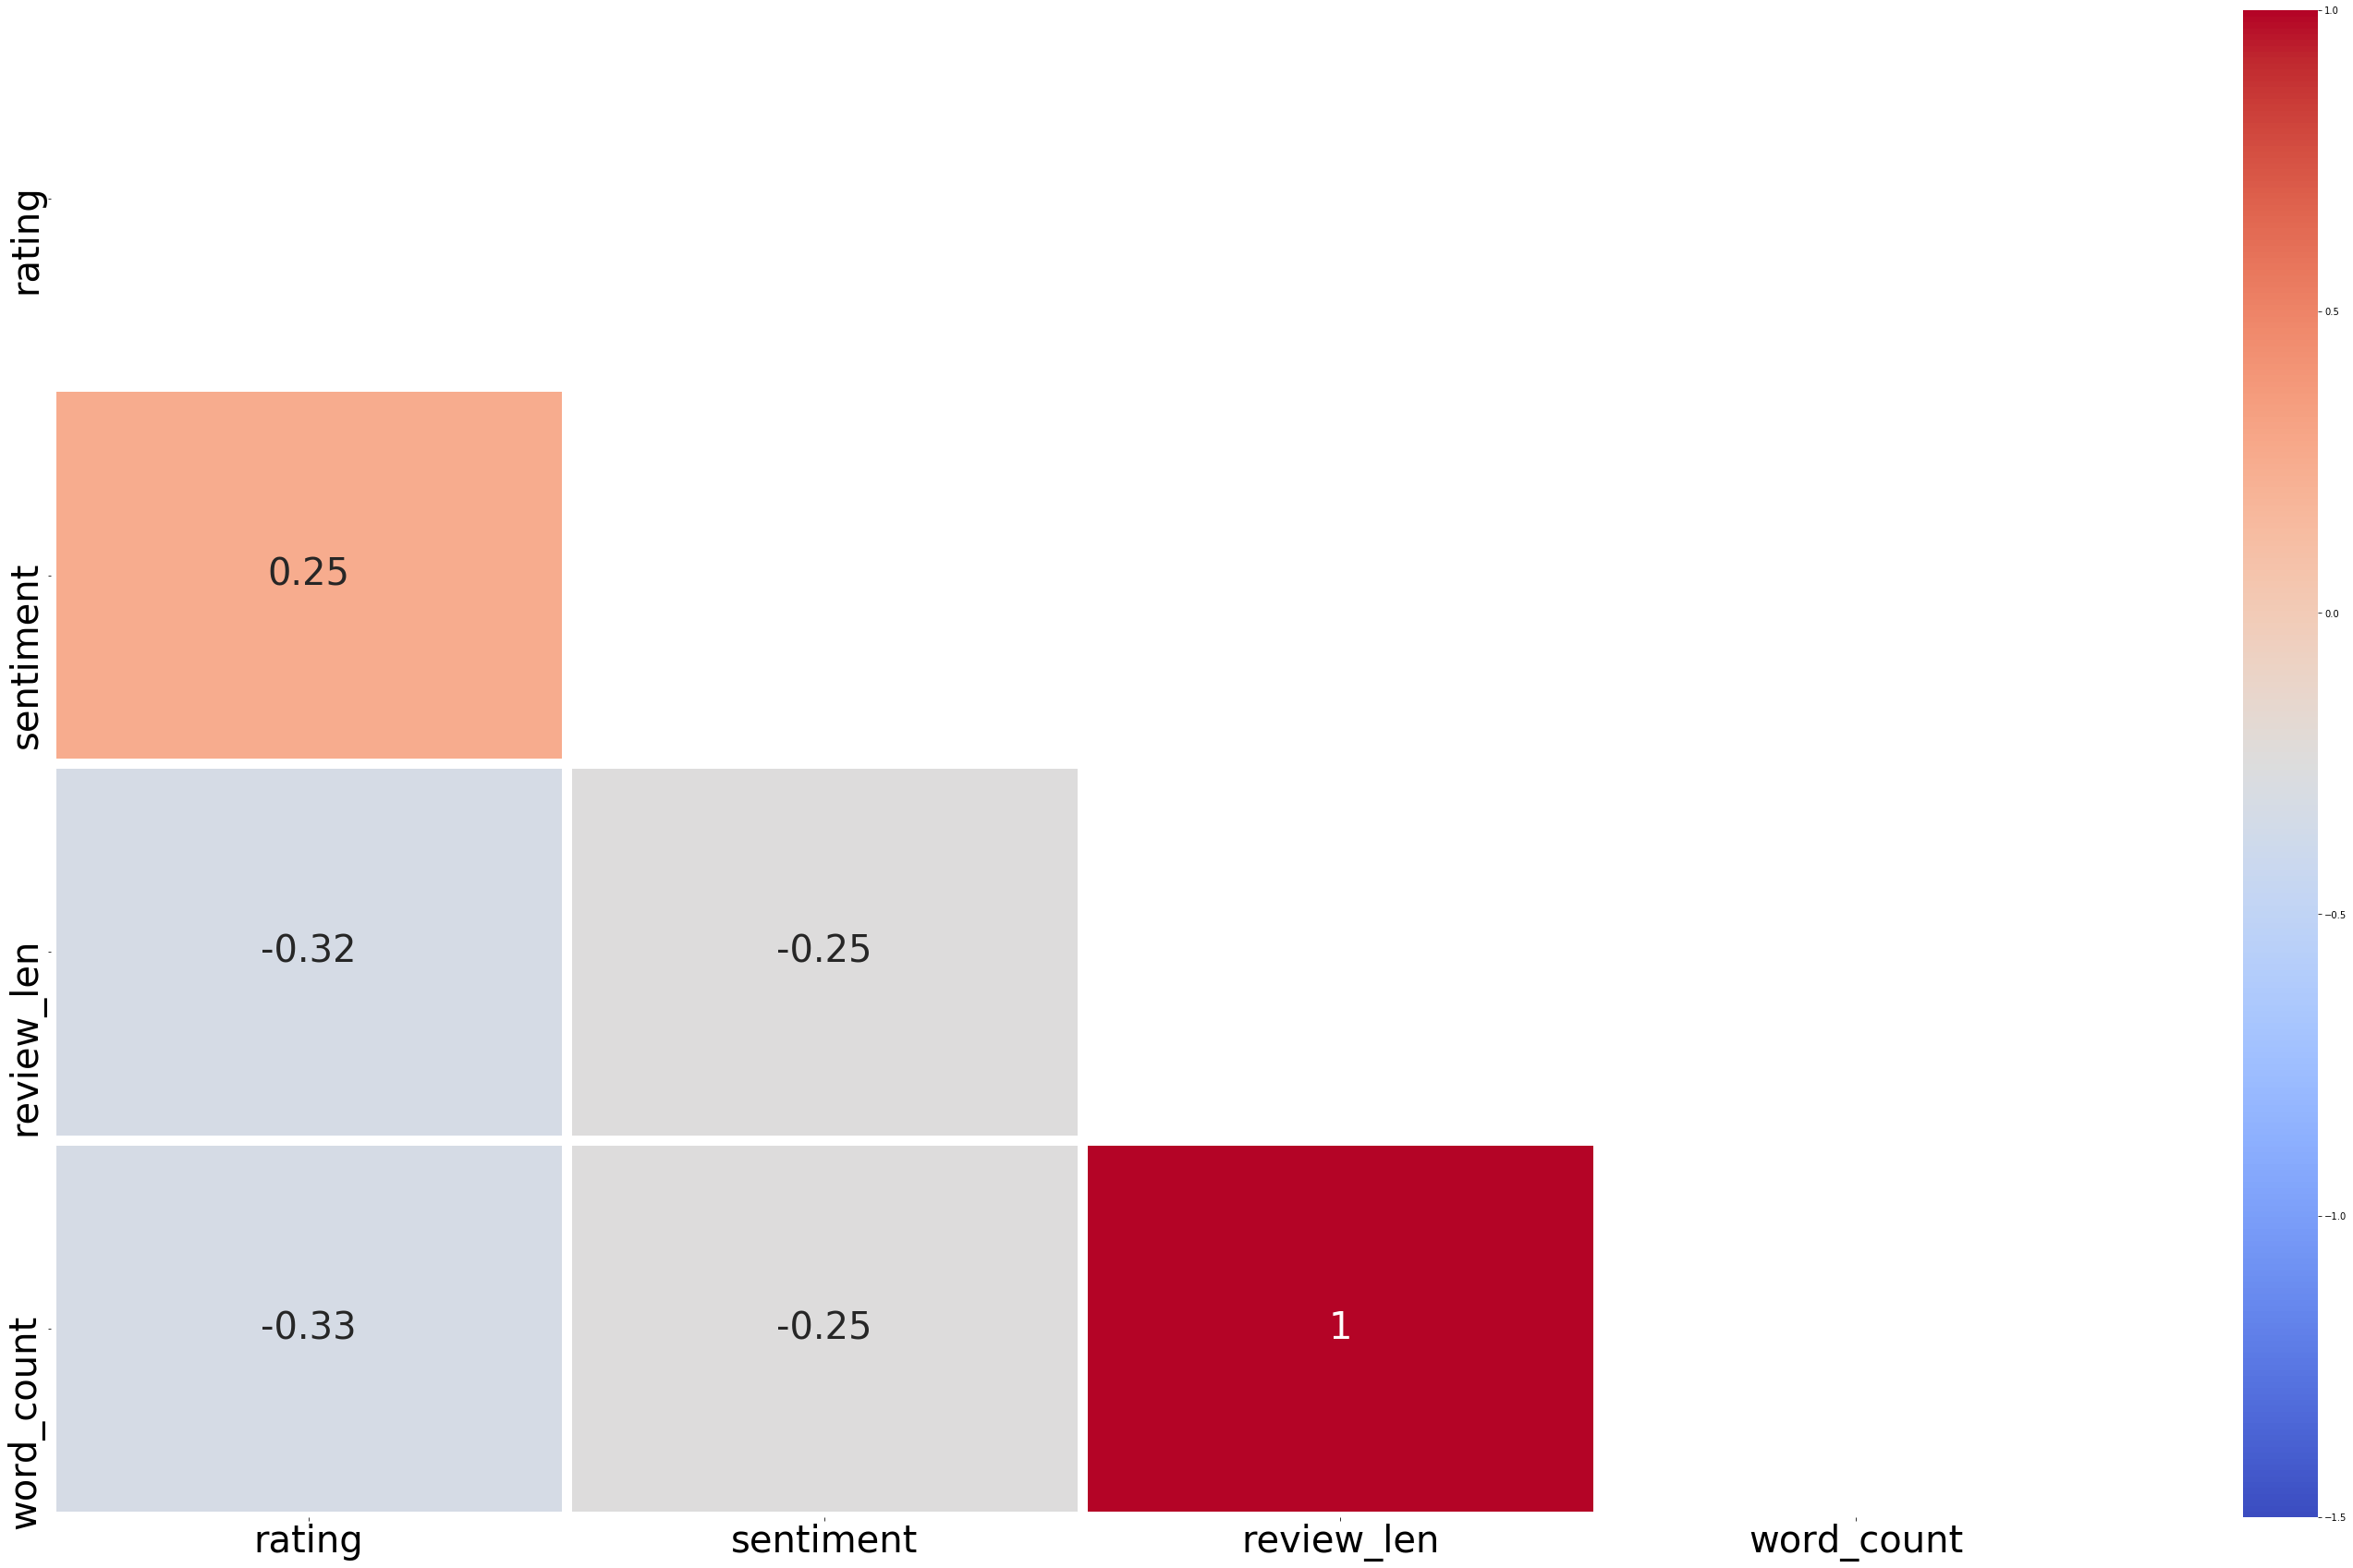

In [21]:
correlation = df[['rating','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [22]:
df

,rating,lemmatized,lemma_str,sentiment,review_len,word_count
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...,0.368750,121,12
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...,0.333333,178,17
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...,0.142361,567,56
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...,0.600000,188,18
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...,0.500000,129,15
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...,0.296338,148,15
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...,0.188280,1064,102
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...,0.712121,216,20
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...,0.700000,99,11
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...,0.386667,141,13


## Let's Examine the Word Frequencies
    

In [23]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist

In [24]:
print(allwords)

['best', 'work', 'bad', 'position', 'perm', 'position', 'stay', 'everyone', 'friendly', 'always', 'great', 'environment', 'work', 'mdp', 'project', 'fun', 'co-worker', 'fun', 'easy', 'along', 'manager', 'capable', 'professional.the', 'easy', 'learn', 'sometimes', 'boring.if', 'give', 'opportunity', 'contractor', 'strict', 'schedule', 'divide', 'section', 'task', 'expect', 'finish', 'duration', 'however', 'leave', 'early', 'personal', 'issue', 'notify', 'supervisor', 'finish', 'rest', 'task', 'flexibility', 'really', 'helpful', 'enjoyable', 'learn', 'manage', 'time', 'section', 'priority', 'overall', 'think', 'hard', 'part', 'learn', 'technology', 'use', 'task', 'nevertheless', 'get', 'able', 'finish', 'everything', 'really', 'quickly', 'last', 'least', 'free', 'meal', 'facility', 'really', 'save', 'money', 'enjoy', 'type', 'cuisine', 'laundry', 'arrive', 'contract', 'amazing', 'experience', 'wonderful', 'company', 'treat', 'employee', 'like', 'family', 'enjoyable', 'part', 'able', 'org

In [25]:
mostcommon = FreqDist(allwords).most_common(100)

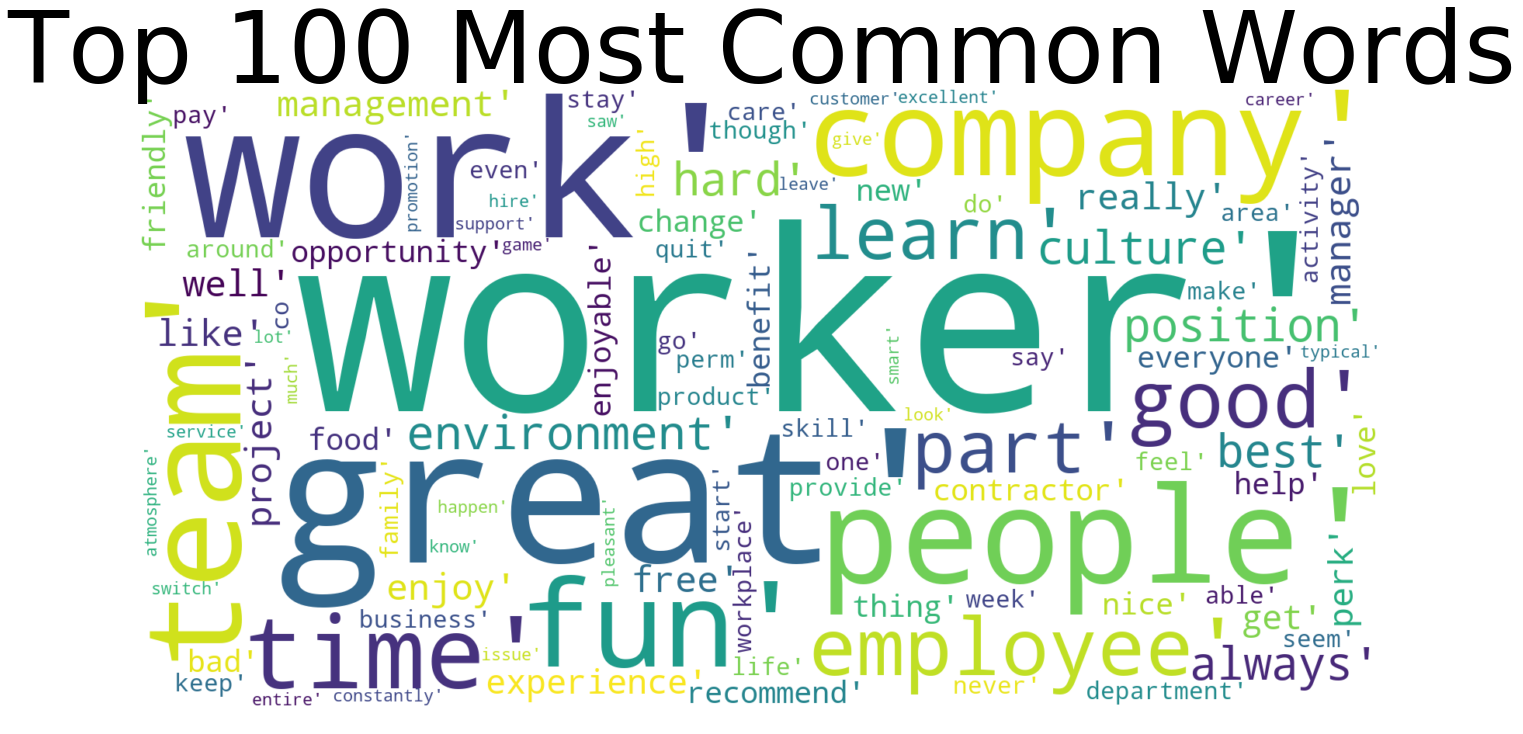

In [26]:
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)

plt.tight_layout(pad=0)
plt.show()

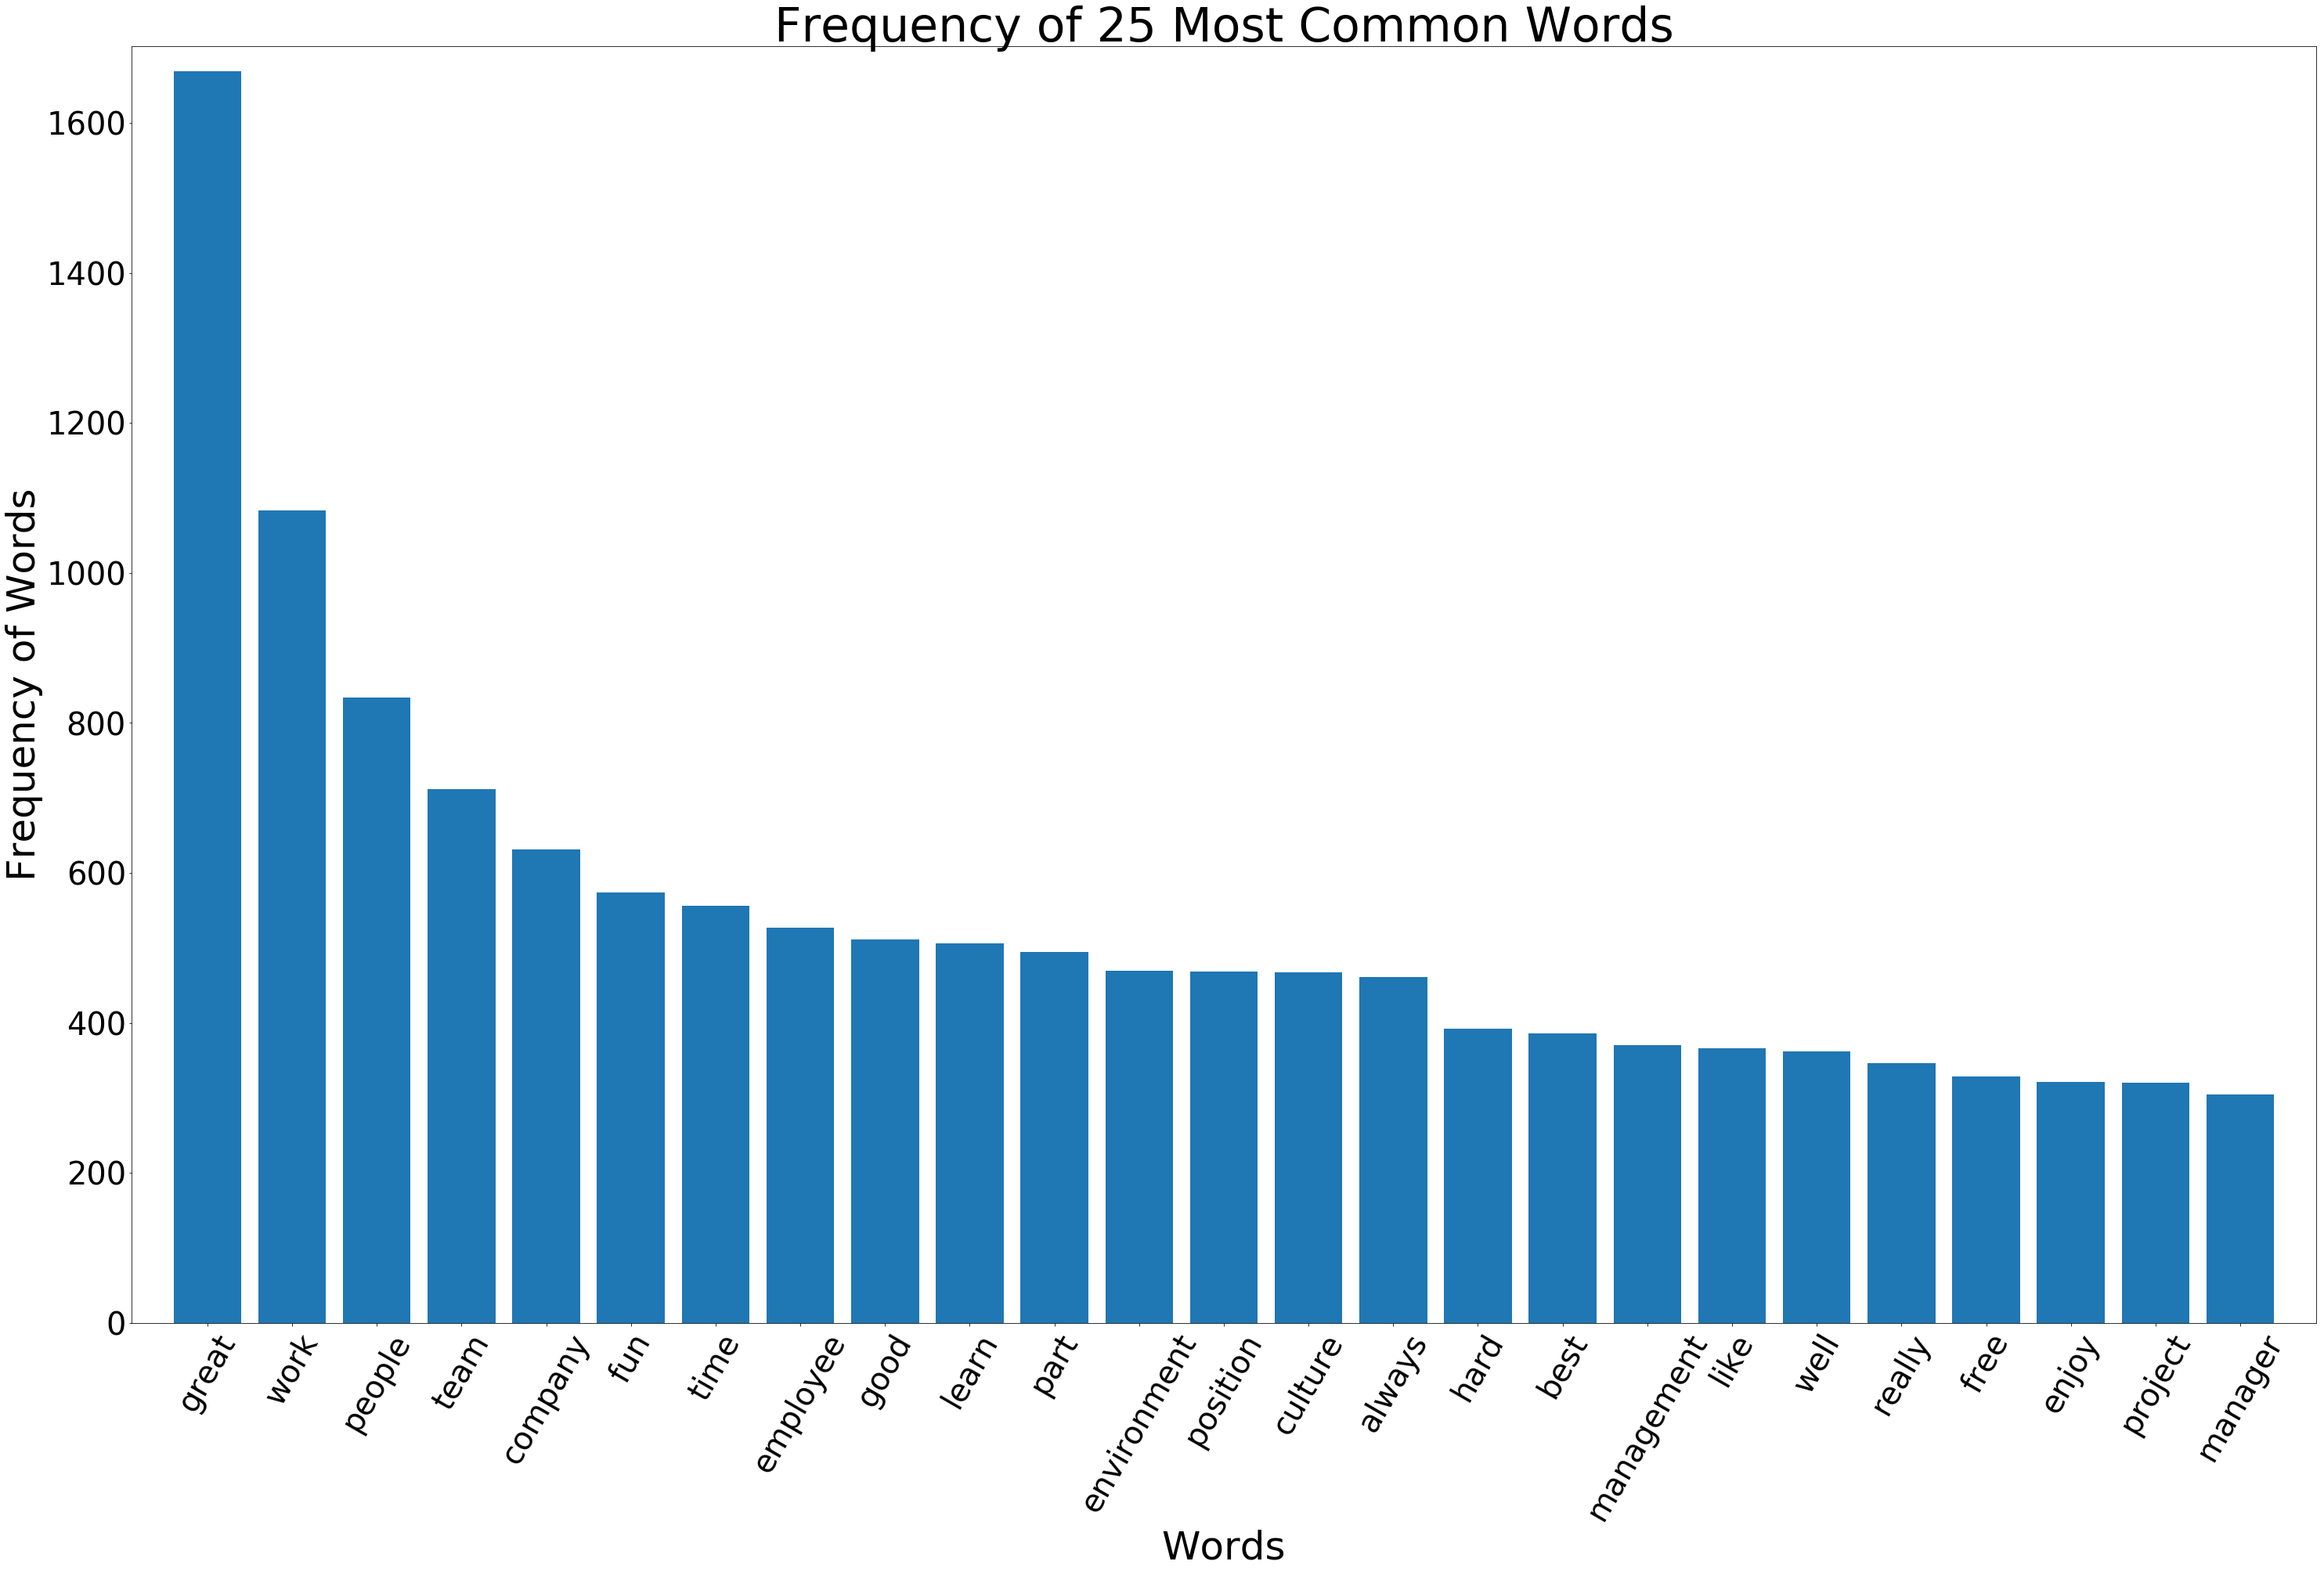

In [27]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
# create a figure
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [28]:
group_by = df.groupby('rating')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

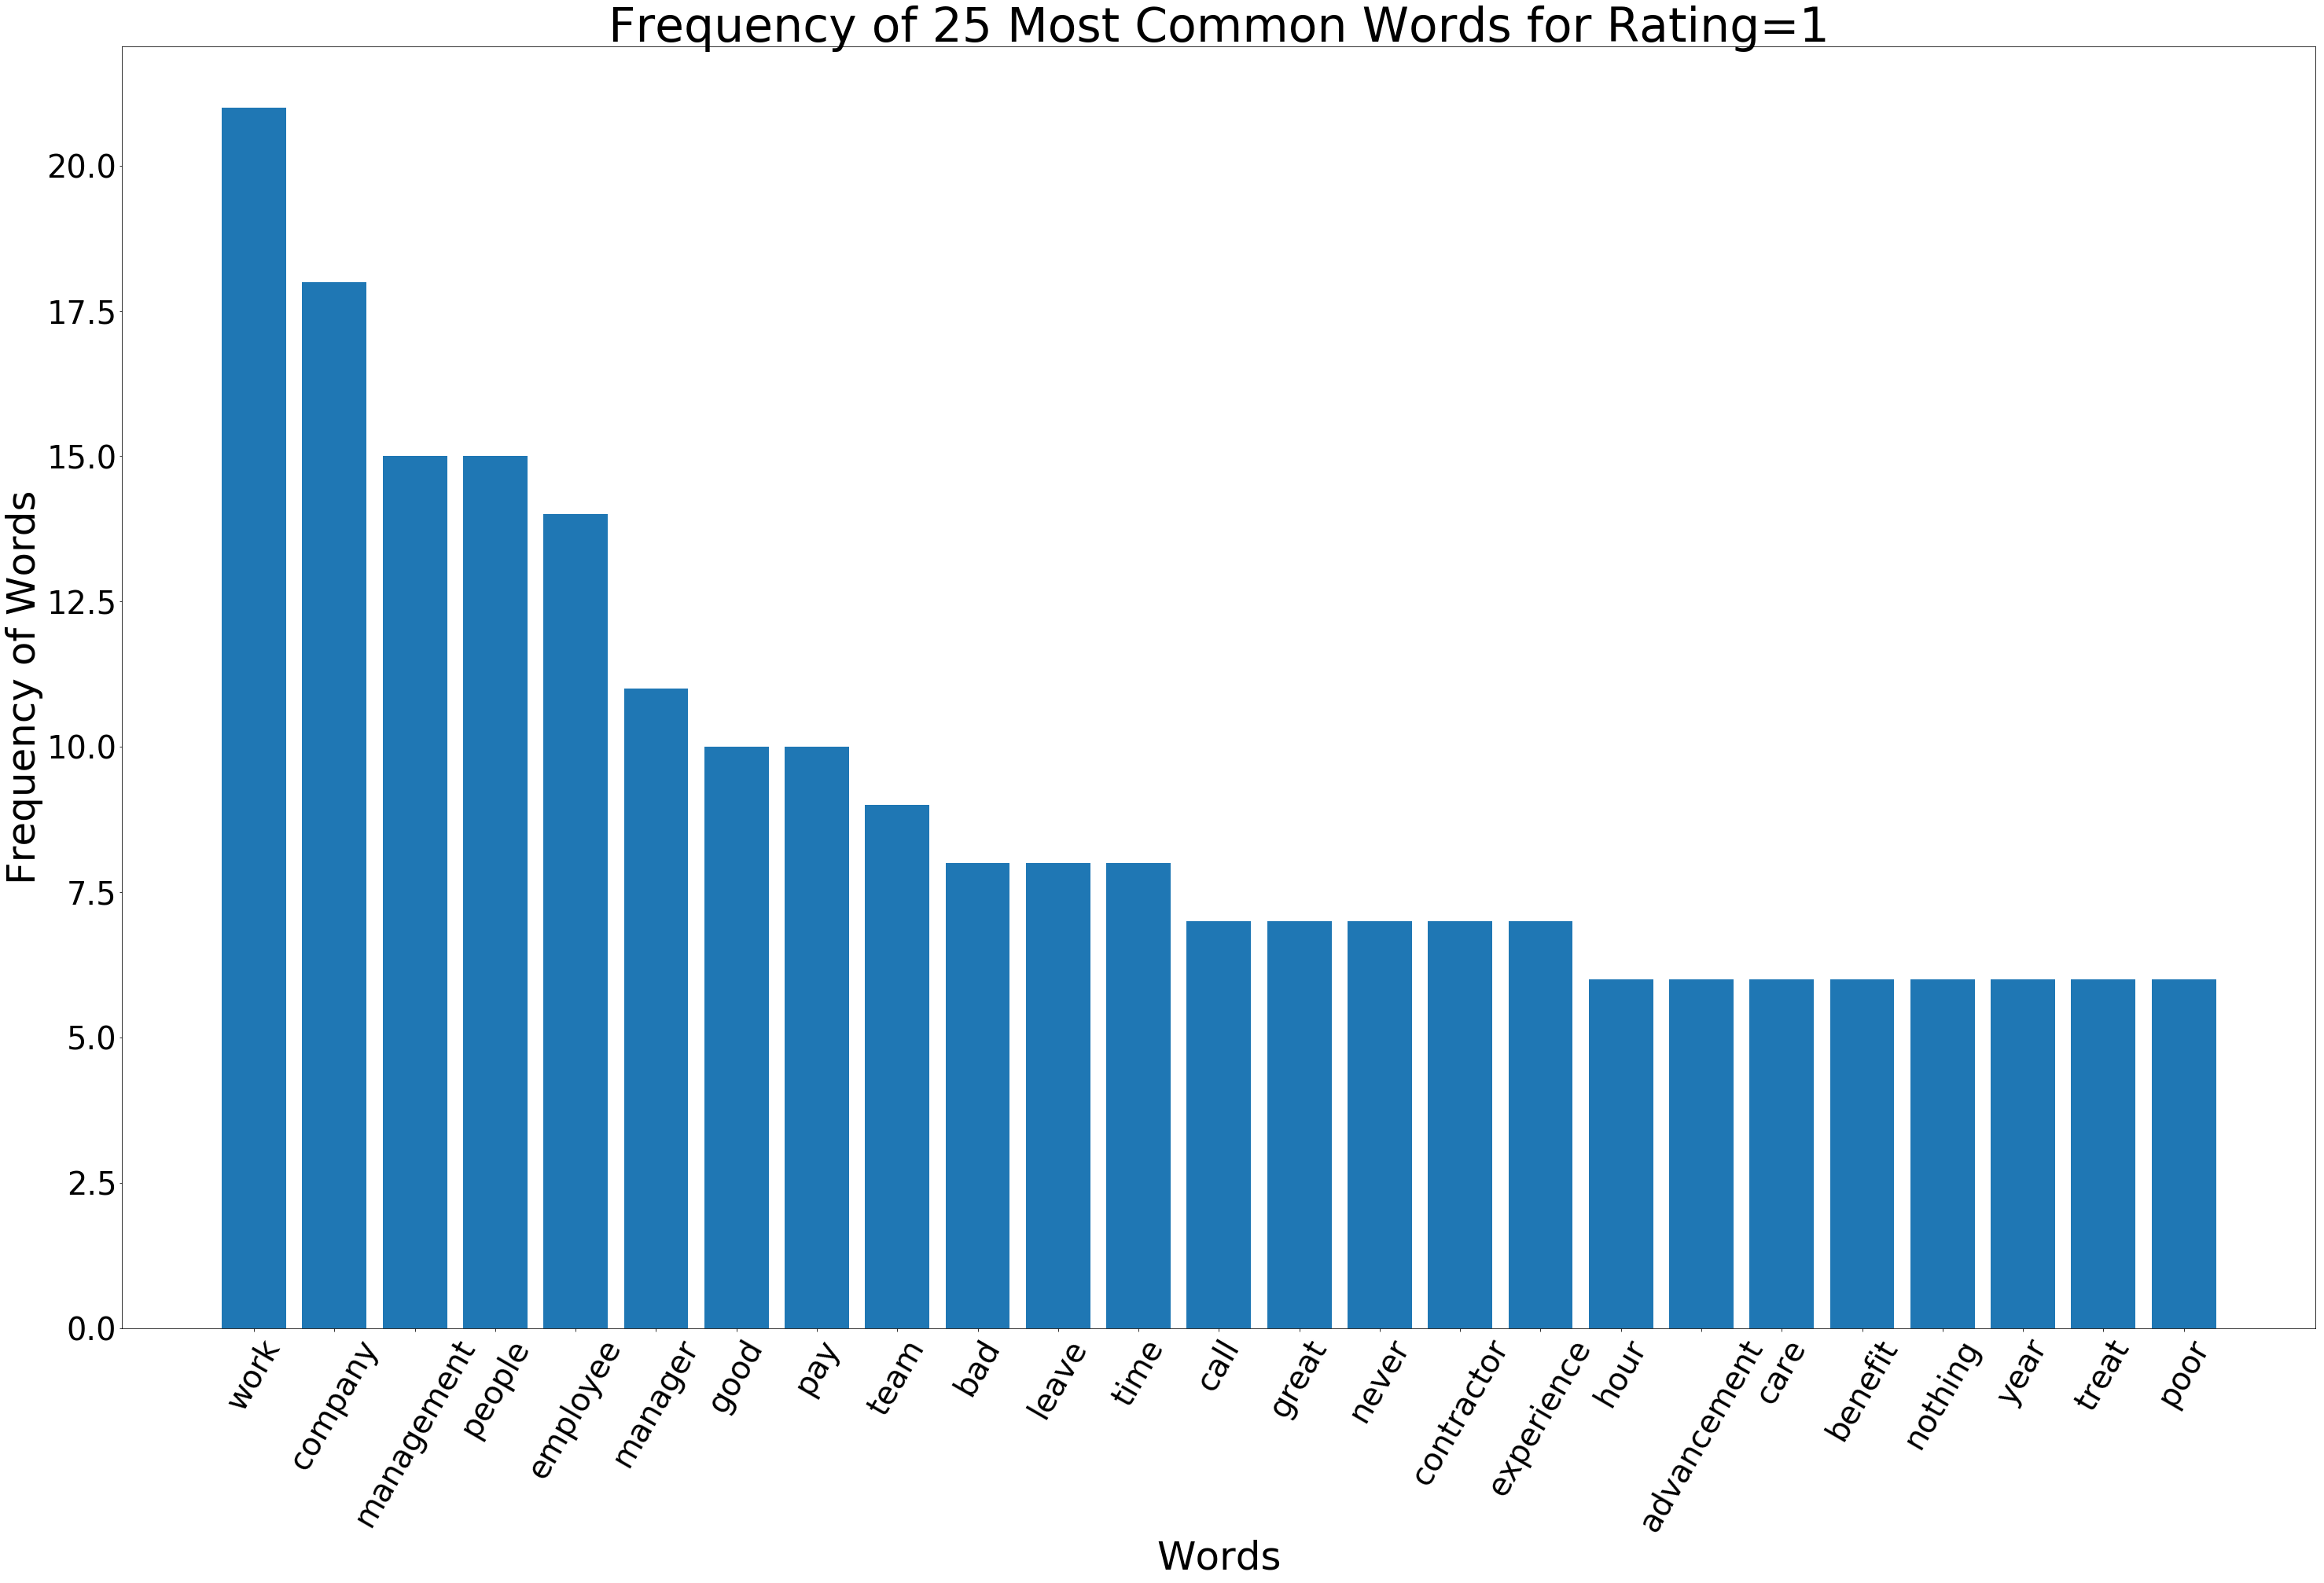

In [29]:
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]

plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=1', fontsize=60)
plt.show()

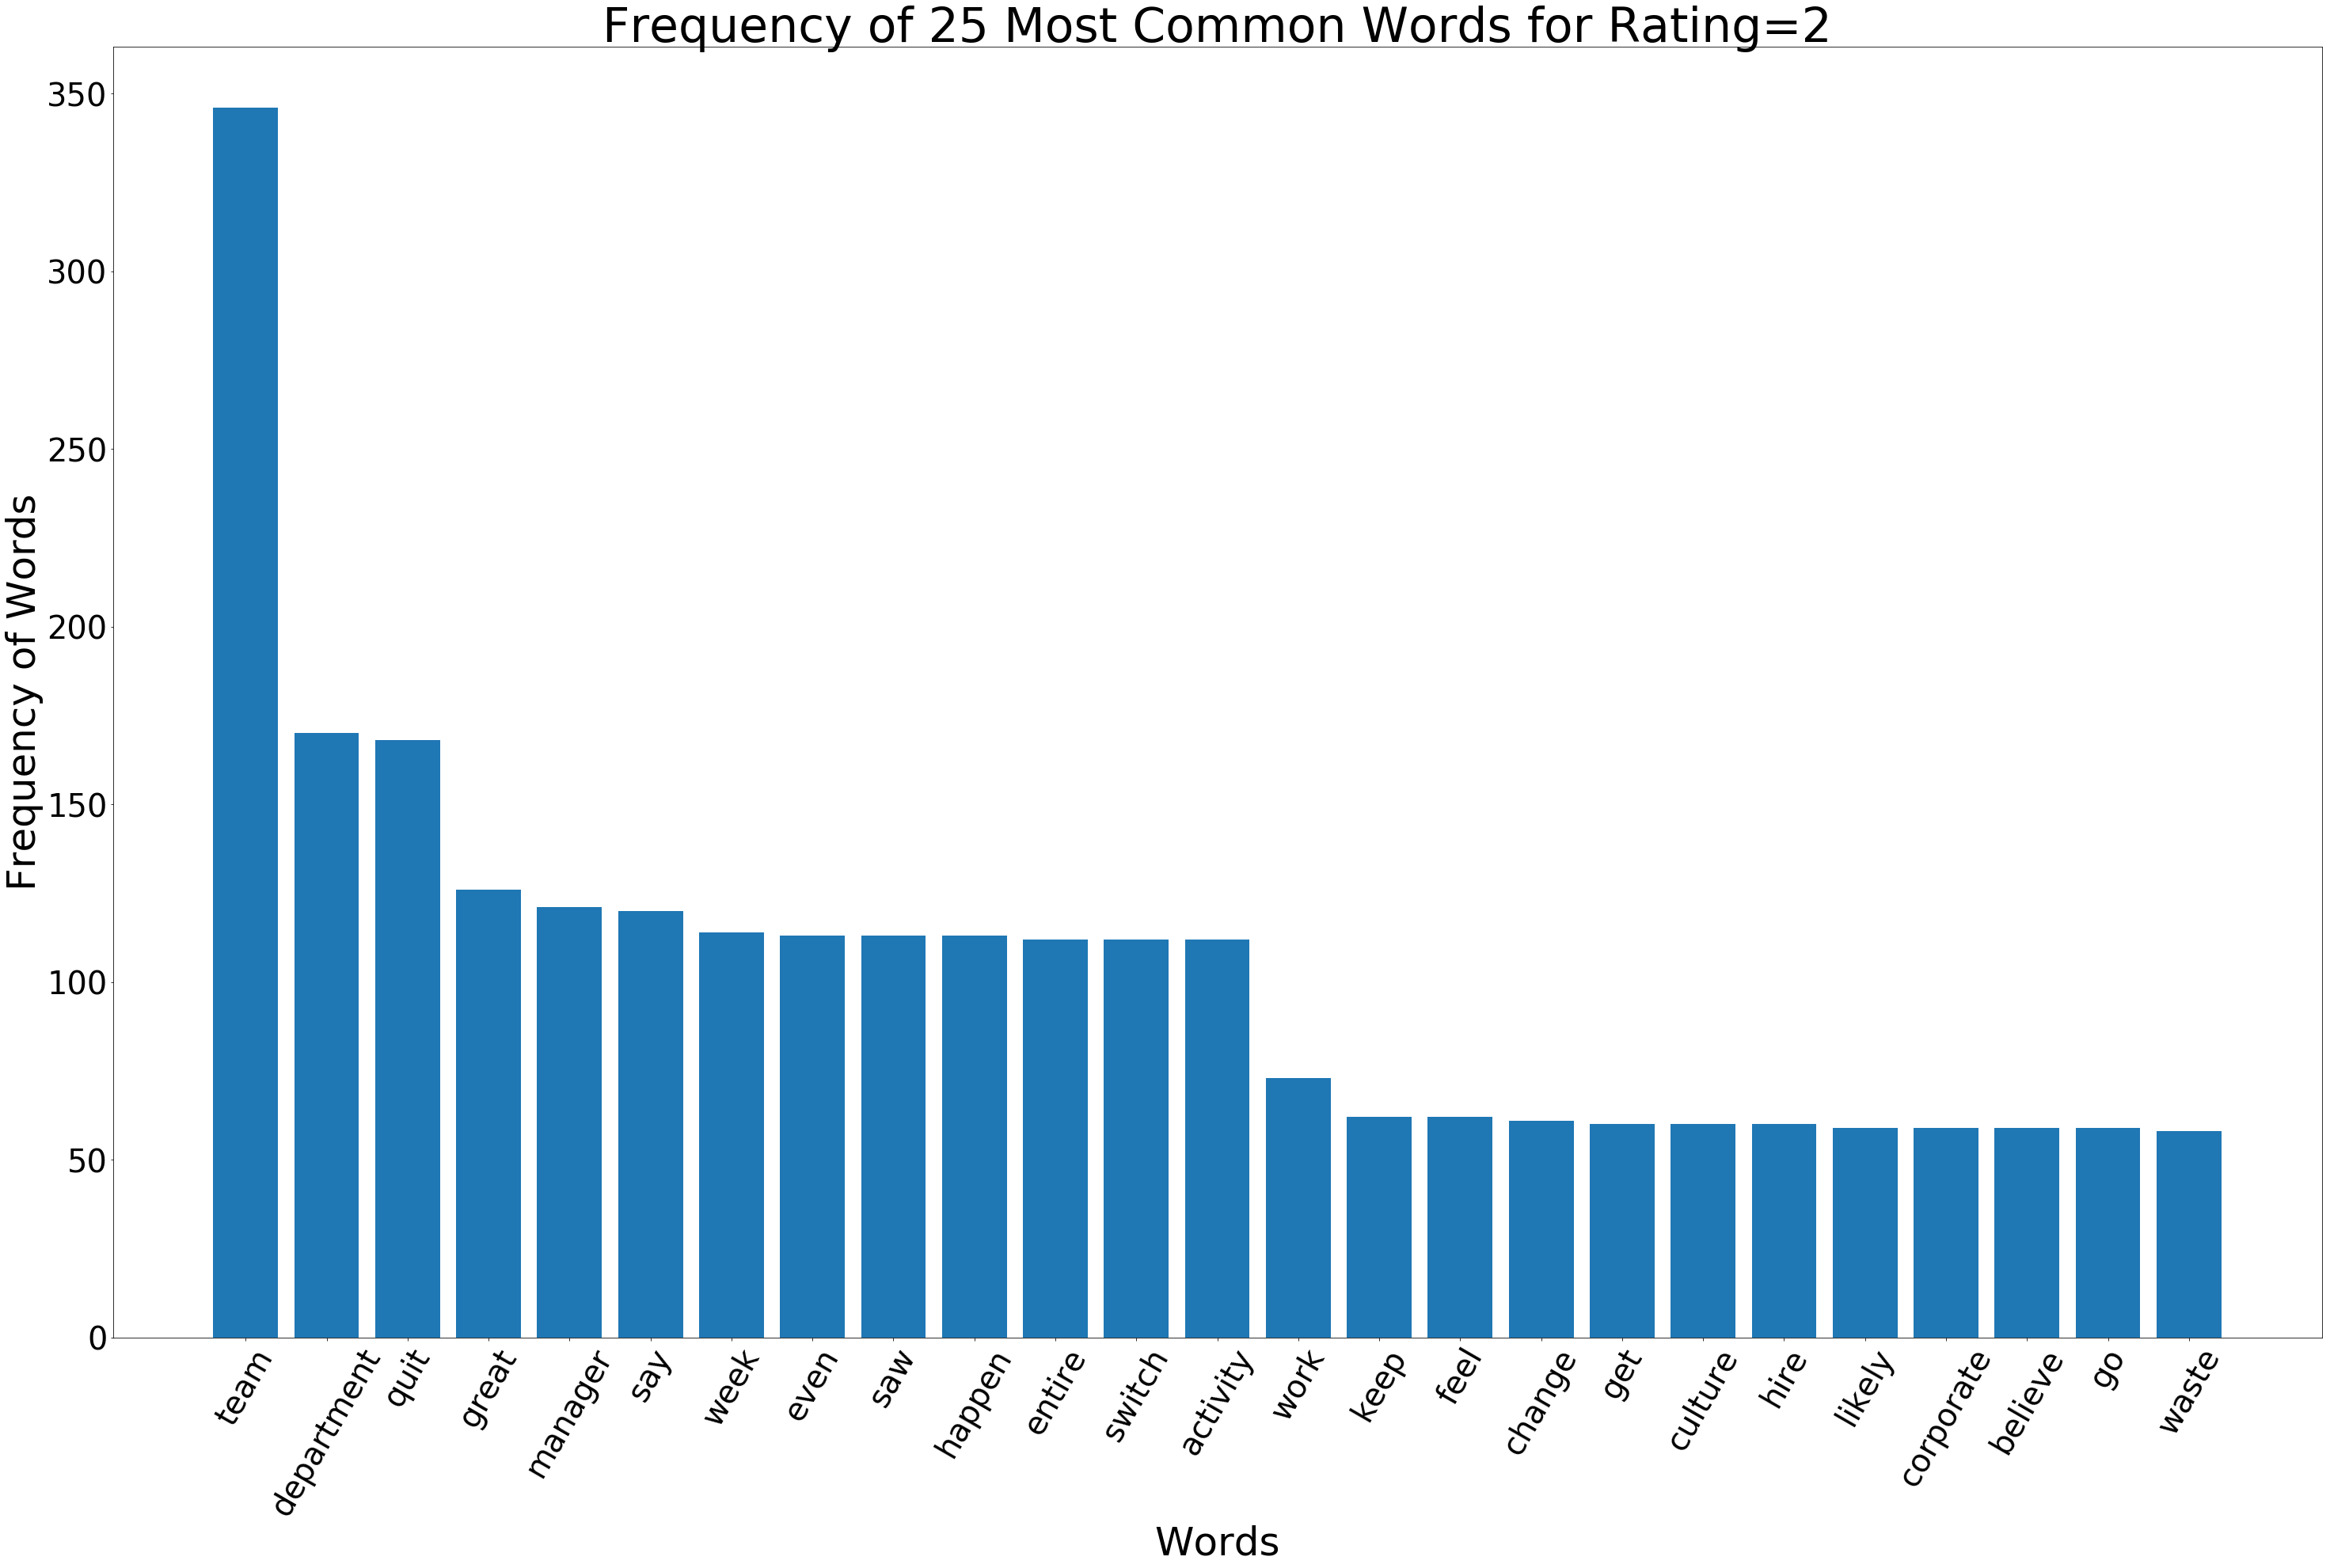

In [30]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=2', fontsize=60)
plt.show()

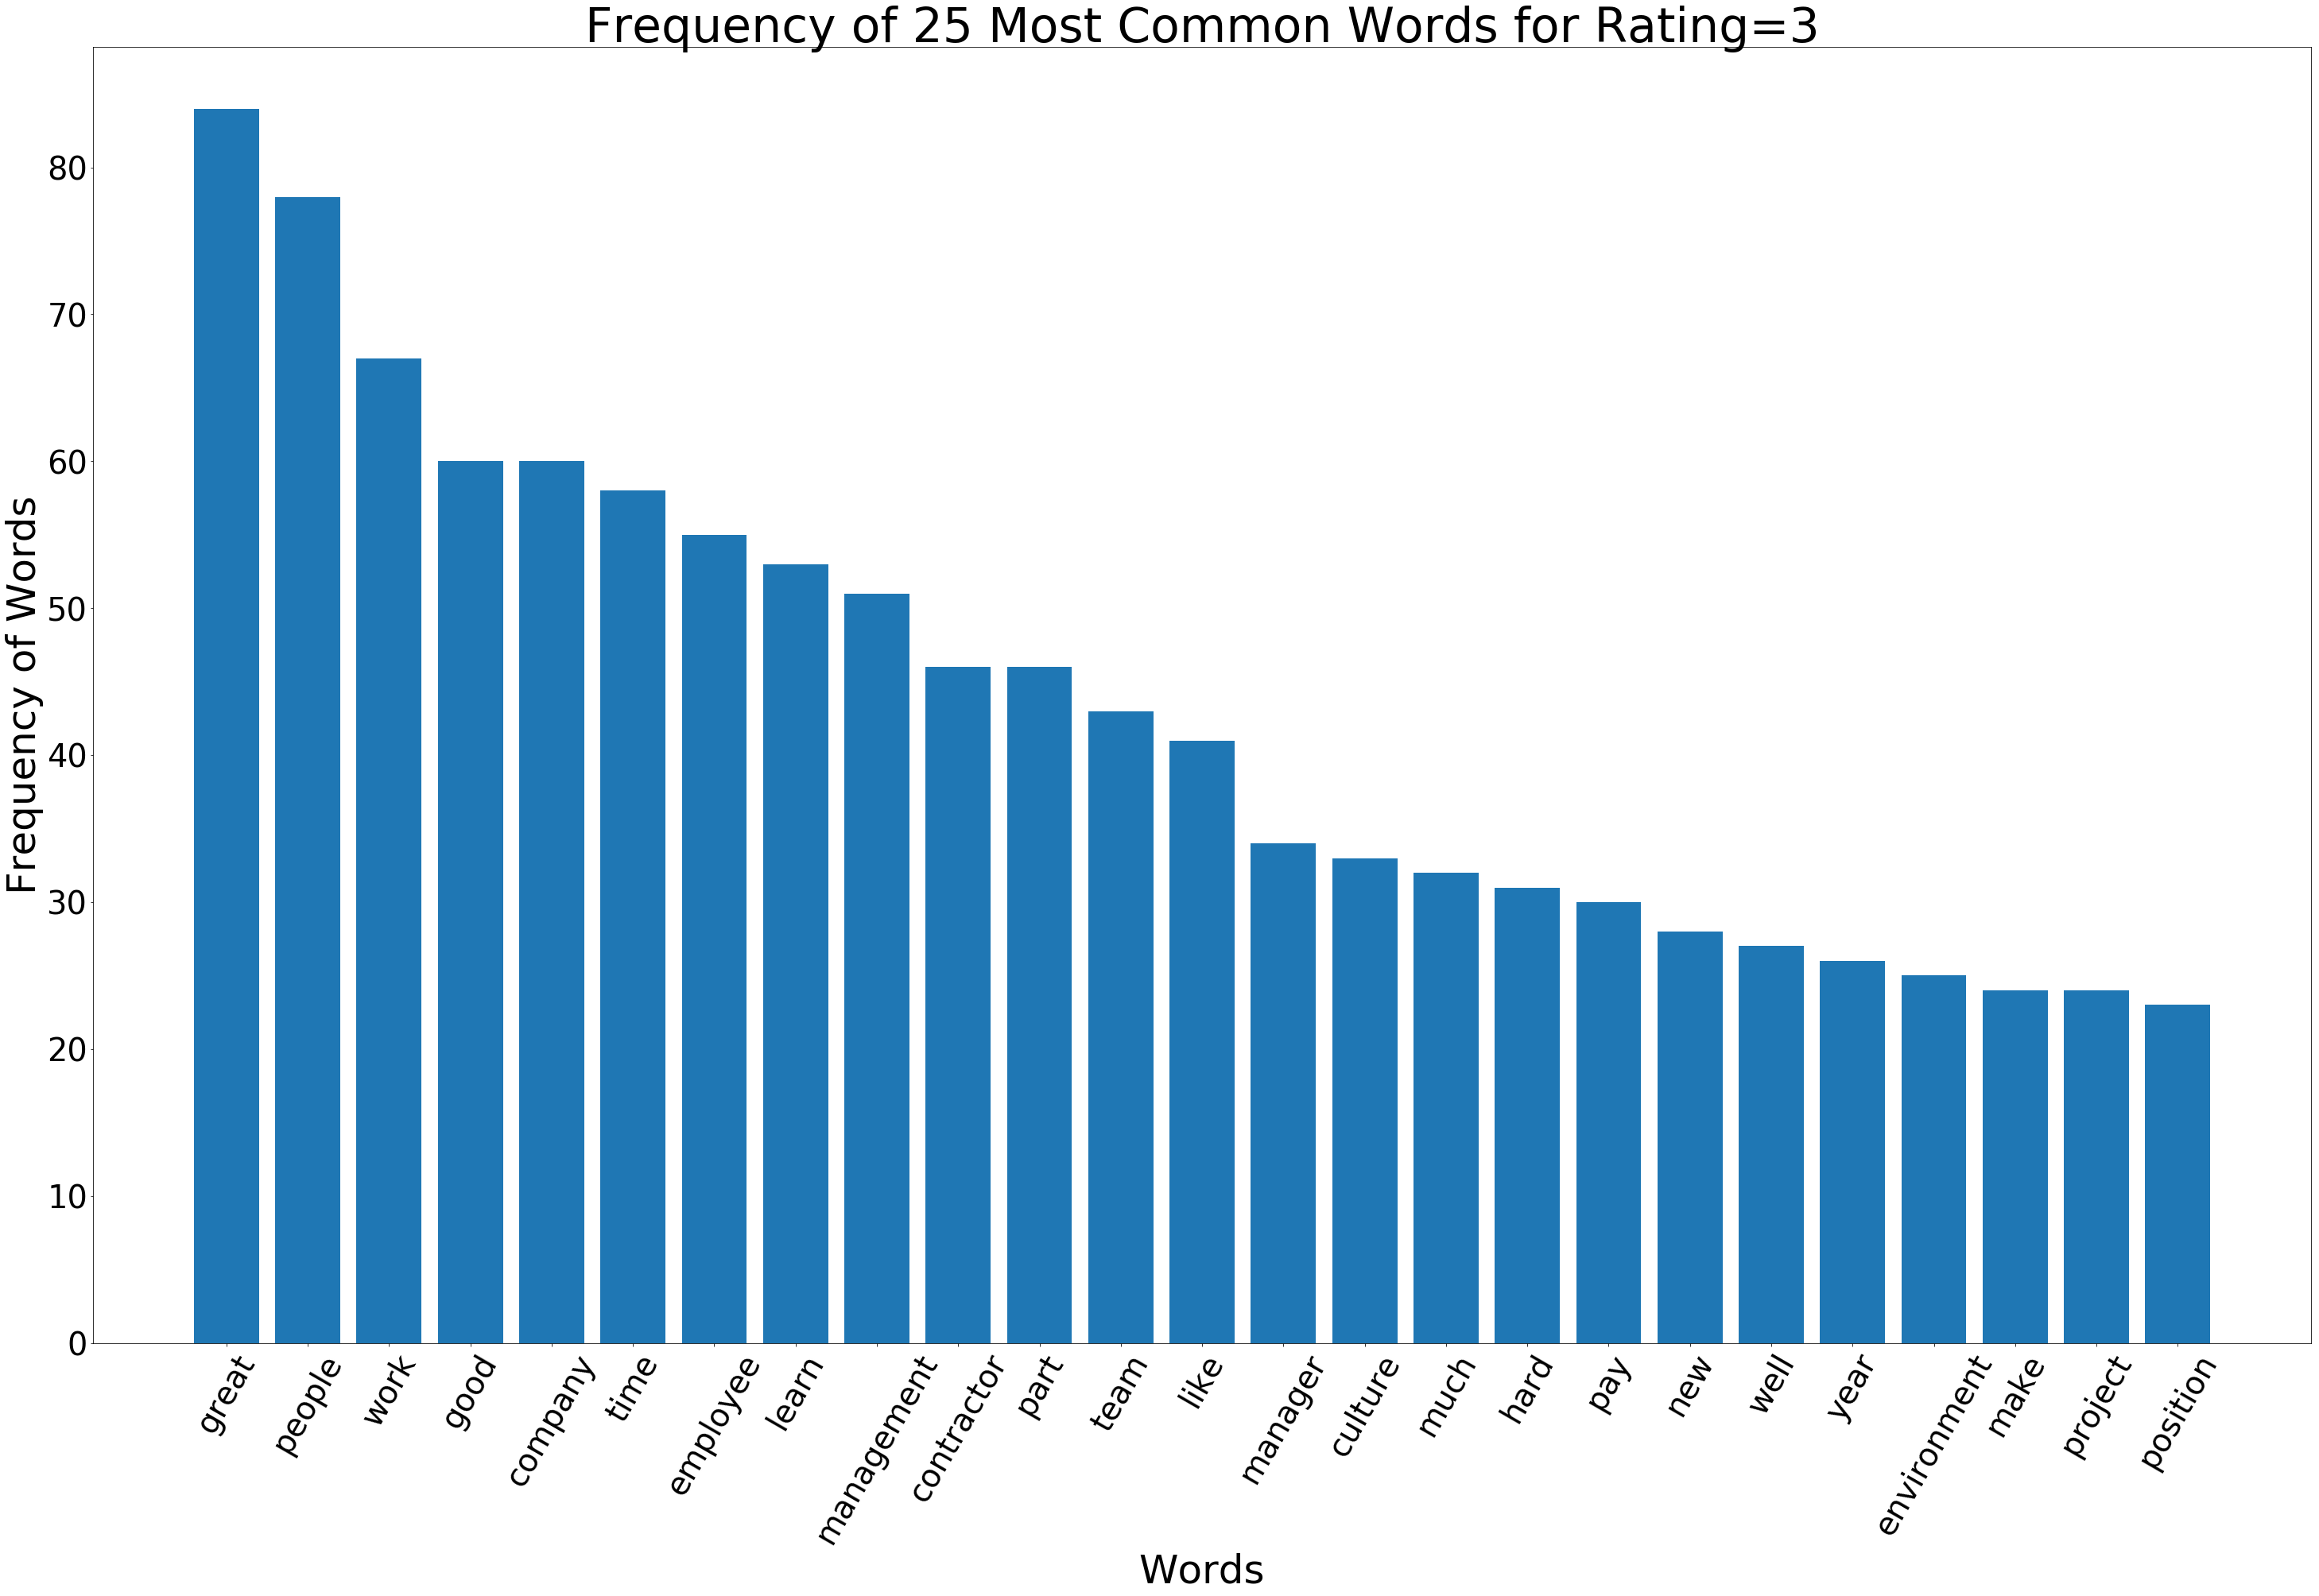

In [31]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=3', fontsize=60)
plt.show()

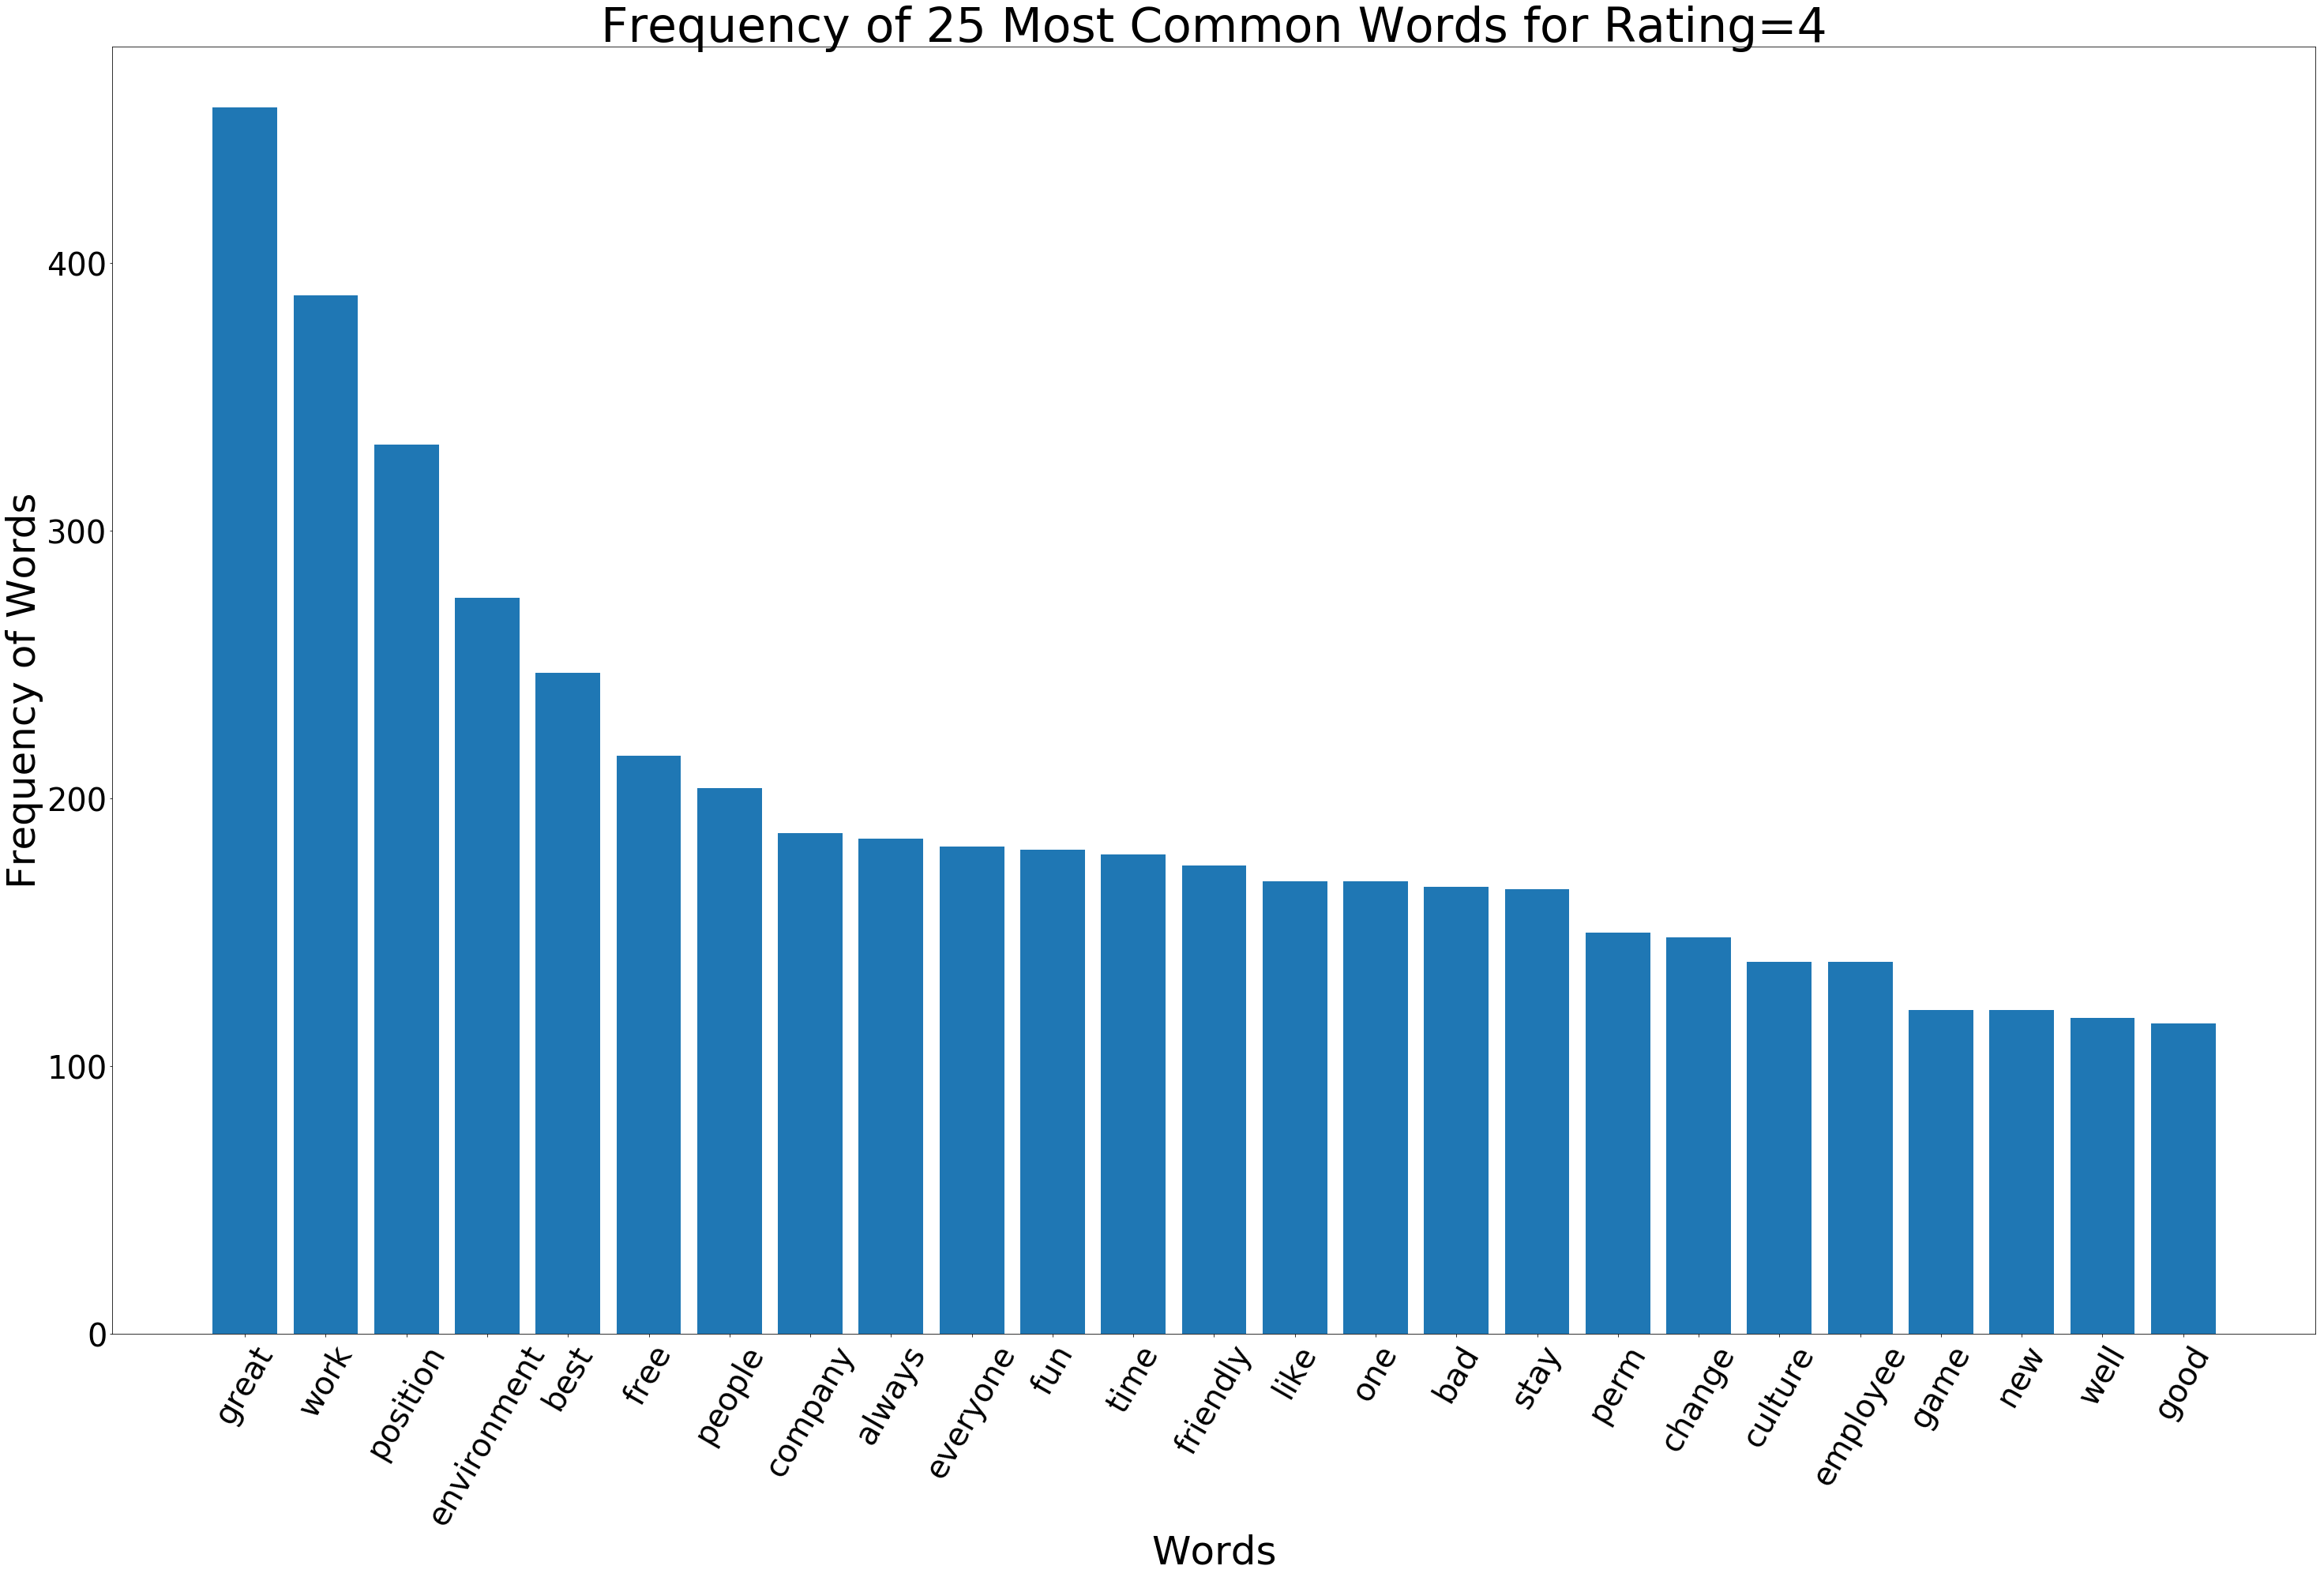

In [32]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]
plt.figure(figsize=(50,30))
plt.bar(words3, freq3)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=4', fontsize=60)
plt.show()

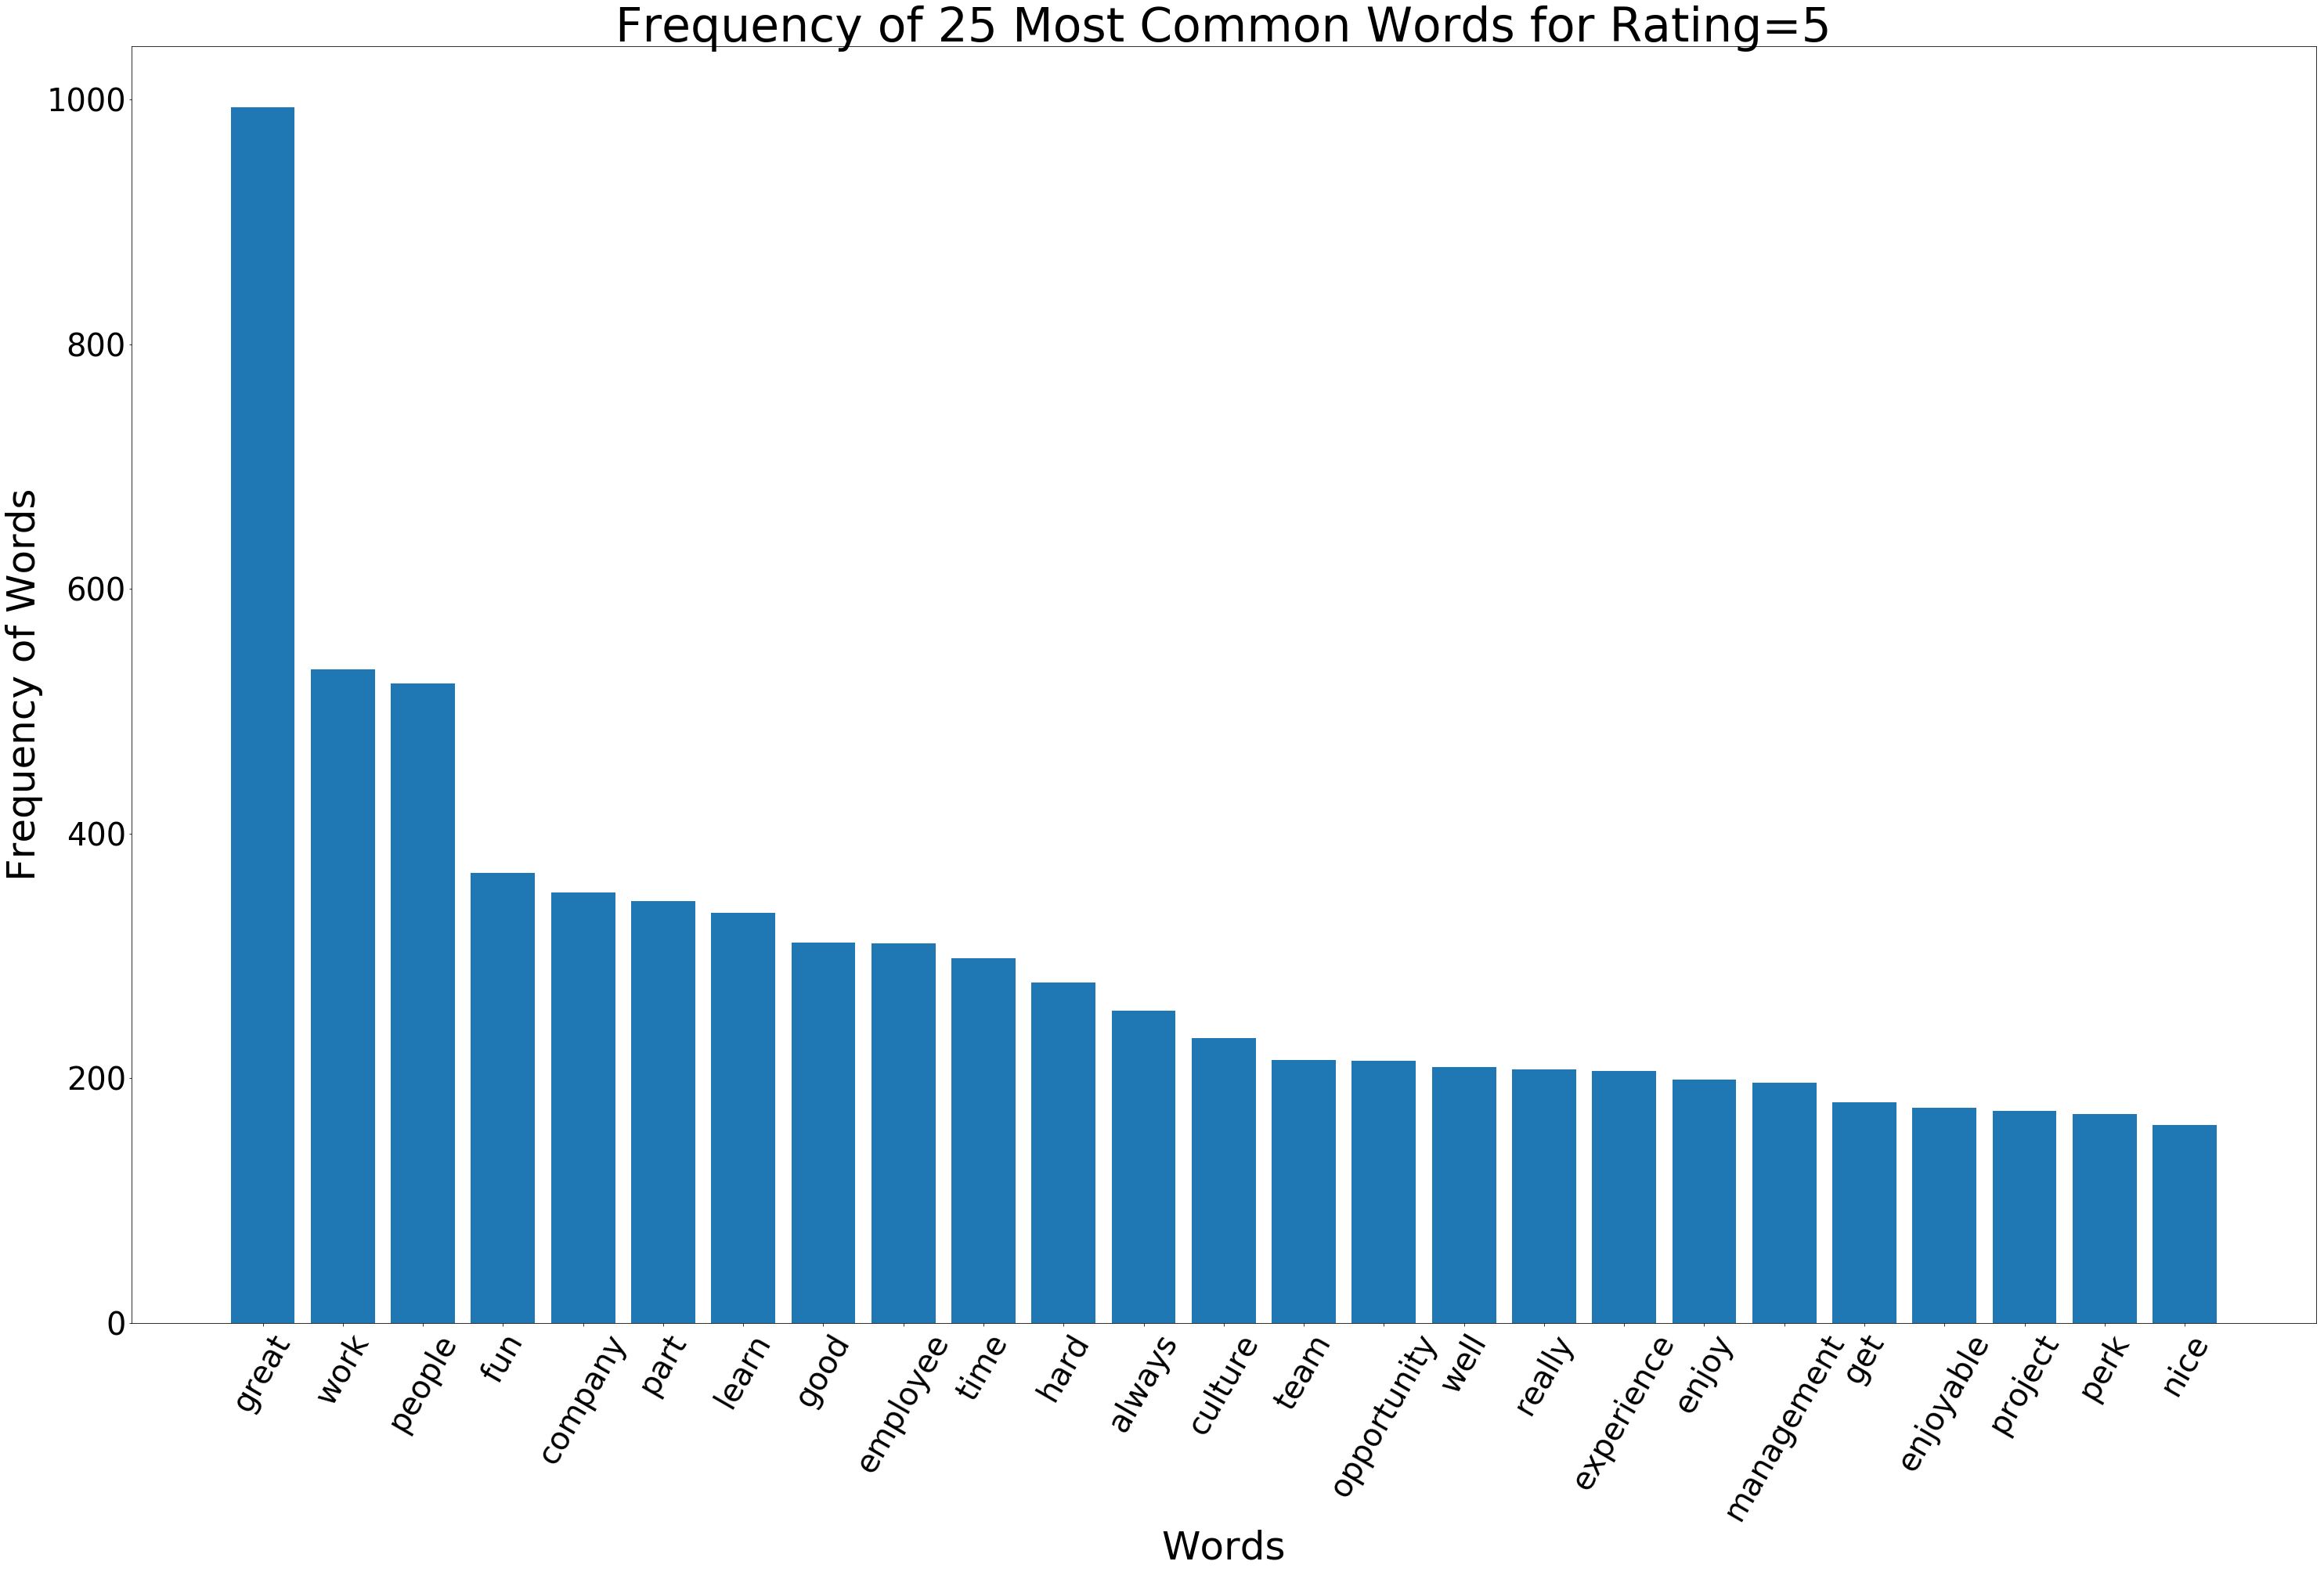

In [33]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.figure(figsize=(50,30))
plt.bar(words4, freq4)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=5', fontsize=60)
plt.show()

In [34]:
df

,rating,lemmatized,lemma_str,sentiment,review_len,word_count
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...,0.368750,121,12
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...,0.333333,178,17
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...,0.142361,567,56
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...,0.600000,188,18
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...,0.500000,129,15
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...,0.296338,148,15
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...,0.188280,1064,102
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...,0.712121,216,20
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...,0.700000,99,11
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...,0.386667,141,13


# Topic Modeling

In [35]:
# you have to feed strings into a countvec
# max_df=0.9 we will remove words which appear in more than 90% of the reviews
# min_df=25 we will remove words which appear in less than 25 reviews

# Creating the vectorizer object
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)

# apply the transformation to create the document term matrix
tf = tf_vectorizer.fit_transform(df['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()


In [36]:
tf

<3122x441 sparse matrix of type '<class 'numpy.int64'>'
	with 42404 stored elements in Compressed Sparse Row format>

In [37]:
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,150,ability,able,activity,actually,add,advance,advancement,advice,again,...,willing,wish,without,wonderful,work,worker,workplace,world,year,you
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [38]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)

In [39]:
print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [40]:
no_top_words = 15

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
free good employee perk work nice enjoy fun people environment lunch contractor offer room come
Topic 1:
position environment great work everyone friendly best bad stay always perm employment express awesome staff
Topic 2:
learn well great company opportunity help always really new team part product benefit work able
Topic 3:
team department quit even manager activity say happen head entire saw switch goal try service
Topic 4:
hard part people fun get workplace worker co learn management enjoyable customer work go good
Topic 5:
time work pay management manager company business team feel keep employee much worker leave contractor
Topic 6:
great week area though map information high hire assignment keep believe quickly interaction fill duty
Topic 7:
great employee life promotion career experience atmosphere contract quality culture security company another balance food
Topic 8:
one fun do recommend company like know love people look day anyone around freedom never
Topic 9:
great

In [41]:
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
#panel

# NMF with tf-idf

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)

In [43]:
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [44]:
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,150,ability,able,activity,actually,add,advance,advancement,advice,again,...,willing,wish,without,wonderful,work,worker,workplace,world,year,you
0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.176029,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.119044,0.188010,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.0,0.137070,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.0,0.257562,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.31953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.142529,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00000,0.0,0.000000,0.000000,0.000000,0.126163,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.111561,0.000000,0.000000
7,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.108865,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.149945,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)

In [46]:
display_topics(nmf, tfidf_feature_names, no_top_words) 

Topic 0:
position perm bad stay friendly everyone best environment always work great learn difficult go dish
Topic 1:
great people project like smart flexibility perk work one experience life world excellent support service
Topic 2:
employee contractor offer outstanding recognition resource available intern opportunity learn perk career security reward catapult
Topic 3:
good nice enjoy work mountain everthing view map travel helpful co clean tip relationship advice
Topic 4:
part enjoyable workplace promotion event able bicycle tear fed set take hard management people care
Topic 5:
recommend fun anyone expire employment look leave great around really time love minded friends freedom
Topic 6:
thank employer individualize temporary impressive fairly card appreciate pay character 150 fill share requirement information
Topic 7:
free lunch snack perform motivate keep thing snacks drinks vibrant invite unique room come best
Topic 8:
team company seem pleasant product business culture atmosphe

In [47]:
nmf_topic_values = nmf.transform(tfidf)
df['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df['lda_topics'] = lda_topic_values.argmax(axis=1)

In [48]:
lda_remap = {0: 'Employee Perks', 1: 'Work Environment', 2: 'Helpful Co-Workers', 3: 'Unknown1', 4: 'Unknown2', 
             5: 'Unknown3', 6: 'Unknown4', 7: 'Career Advancement', 8: 'Recommend Google', 9: 'Org Culture'}

df['lda_topics'] = df['lda_topics'].map(lda_remap)

In [49]:
nmf_remap = {0: 'Work Environment', 1: 'Helpful Co-Workers', 2: 'Opportunities', 3: 'Work Location', 
             4: 'Promotional Opportunties', 5: 'Recommend Google', 6: 'Unknown1', 7: 'Employee Perks', 
             8: 'Team Culture', 9: 'Pay/Benefits'}

df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)

In [50]:
df

,rating,lemmatized,lemma_str,sentiment,review_len,word_count,nmf_topics,lda_topics
0,4,"[best, work, bad, position, perm, position, st...",best work bad position perm position stay ever...,0.368750,121,12,Work Environment,Work Environment
1,4,"[work, mdp, project, fun, co-worker, fun, easy...",work mdp project fun co-worker fun easy along ...,0.333333,178,17,Work Location,Unknown3
2,4,"[contractor, strict, schedule, divide, section...",contractor strict schedule divide section task...,0.142361,567,56,Pay/Benefits,Helpful Co-Workers
3,5,"[contract, amazing, experience, wonderful, com...",contract amazing experience wonderful company ...,0.600000,188,18,Promotional Opportunties,Helpful Co-Workers
4,1,"[condition, safe, management, joke, osha, call...",condition safe management joke osha call cut h...,0.500000,129,15,Team Culture,Unknown1
5,3,"[best, work/life, balance, compensation, peopl...",best work/life balance compensation people sup...,0.296338,148,15,Helpful Co-Workers,Recommend Google
6,4,"[pro, stand, shoulder, giant, build, best, dev...",pro stand shoulder giant build best developer ...,0.188280,1064,102,Team Culture,Helpful Co-Workers
7,5,"[excellent, internship, program, learn, best, ...",excellent internship program learn best practi...,0.712121,216,20,Helpful Co-Workers,Helpful Co-Workers
8,4,"[lay, phone, rebrand, pixel, use, motorola, co...",lay phone rebrand pixel use motorola company s...,0.700000,99,11,Work Location,Helpful Co-Workers
9,4,"[work, challenge, interesting, highly, recomme...",work challenge interesting highly recommend ev...,0.386667,141,13,Work Environment,Helpful Co-Workers


(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

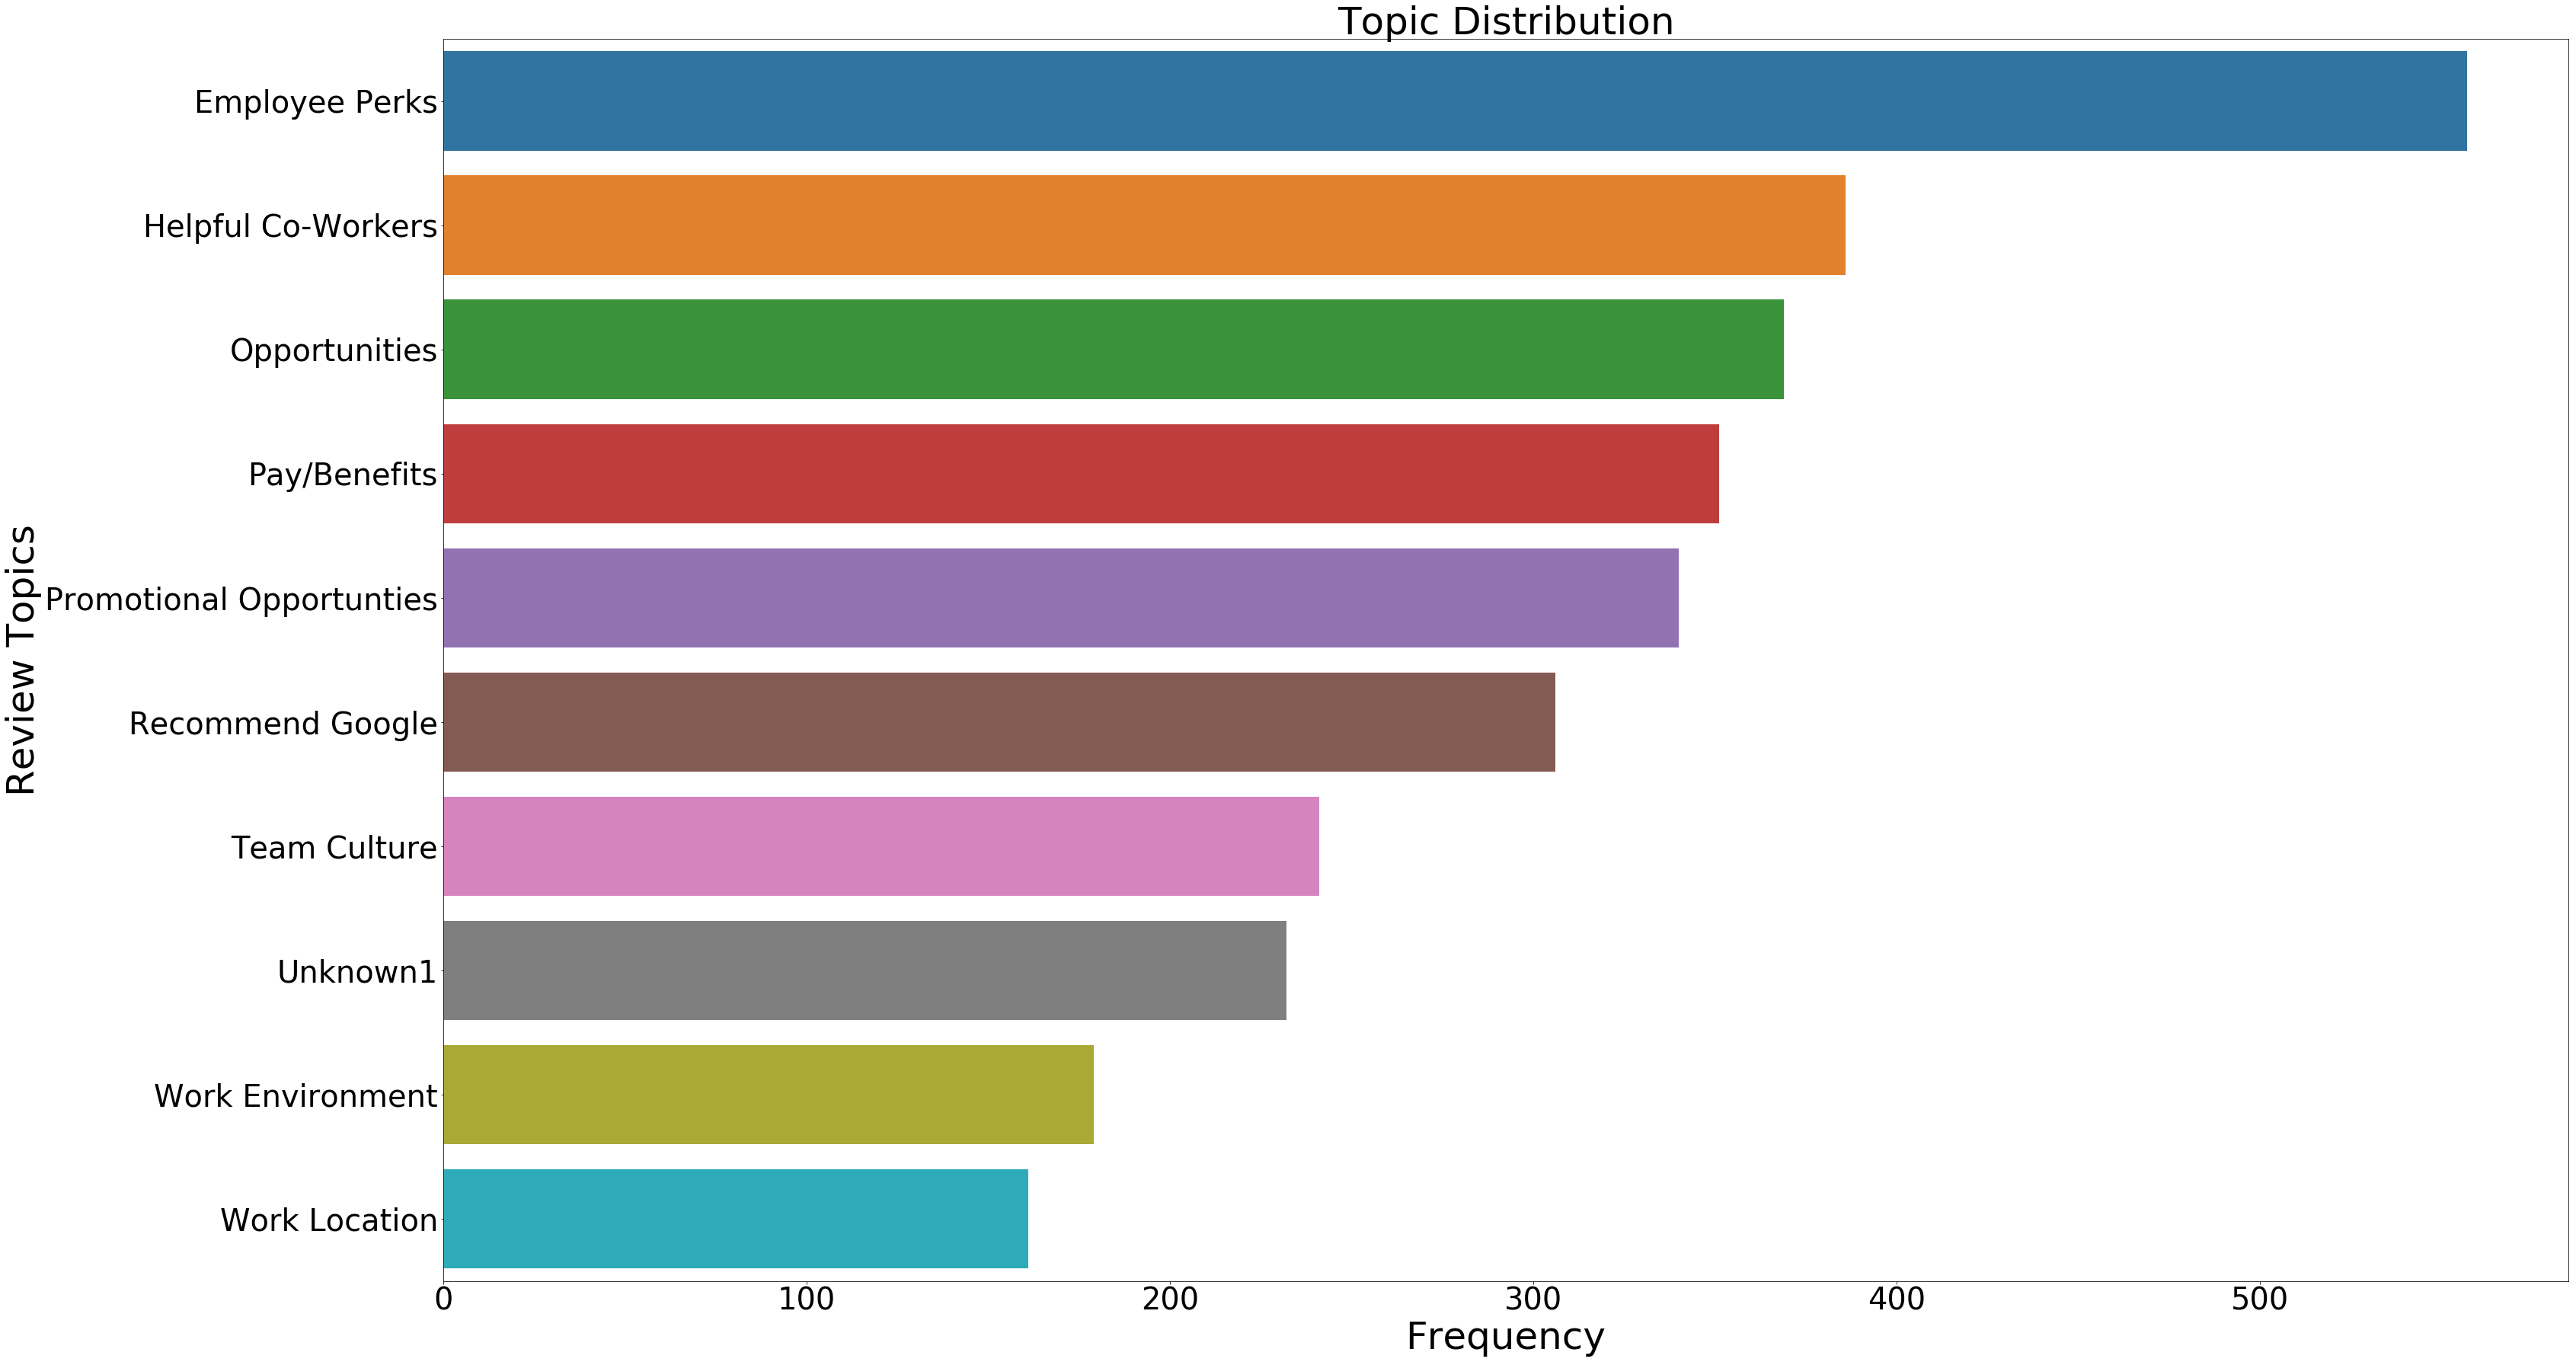

In [51]:
nmf_x = df.nmf_topics.value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

In [52]:
df_low_ratings = df.loc[(df['rating']==1) | (df['rating']==2)]

In [53]:
df_high_ratings = df.loc[(df['rating']==4) | (df['rating']==5)]

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <a list of 10 Text xticklabel objects>)

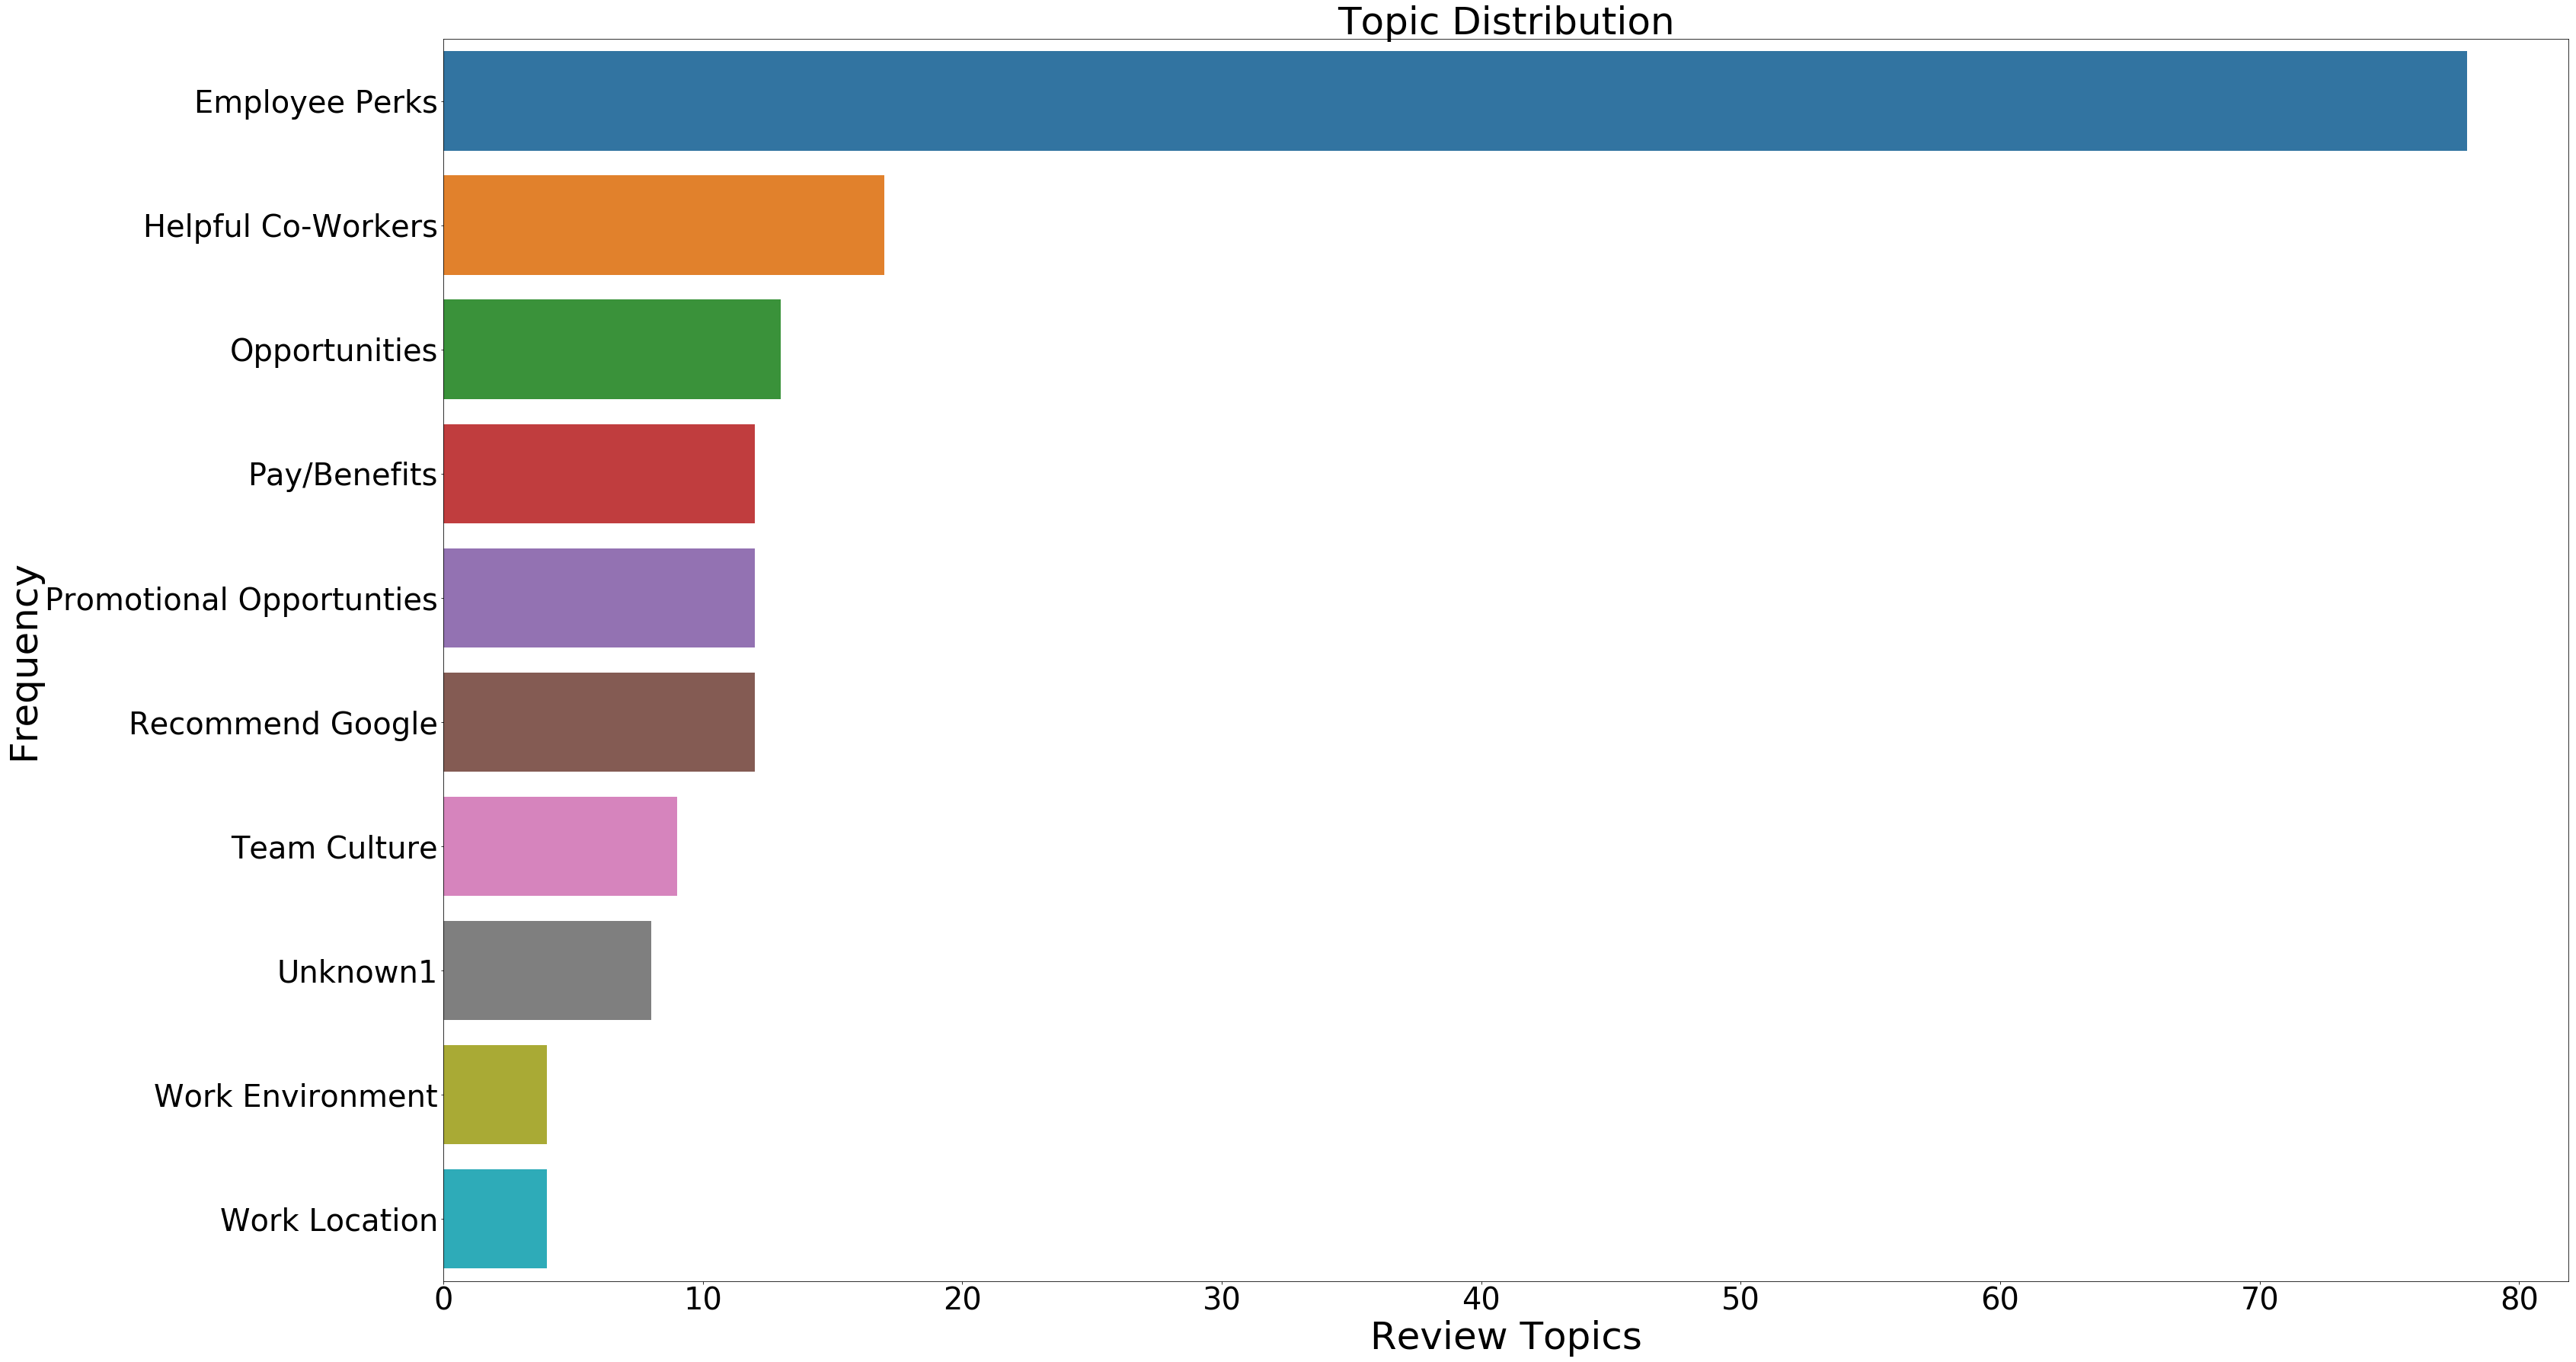

In [54]:
nmf_low_x = df_low_ratings.nmf_topics.value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("Topic Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

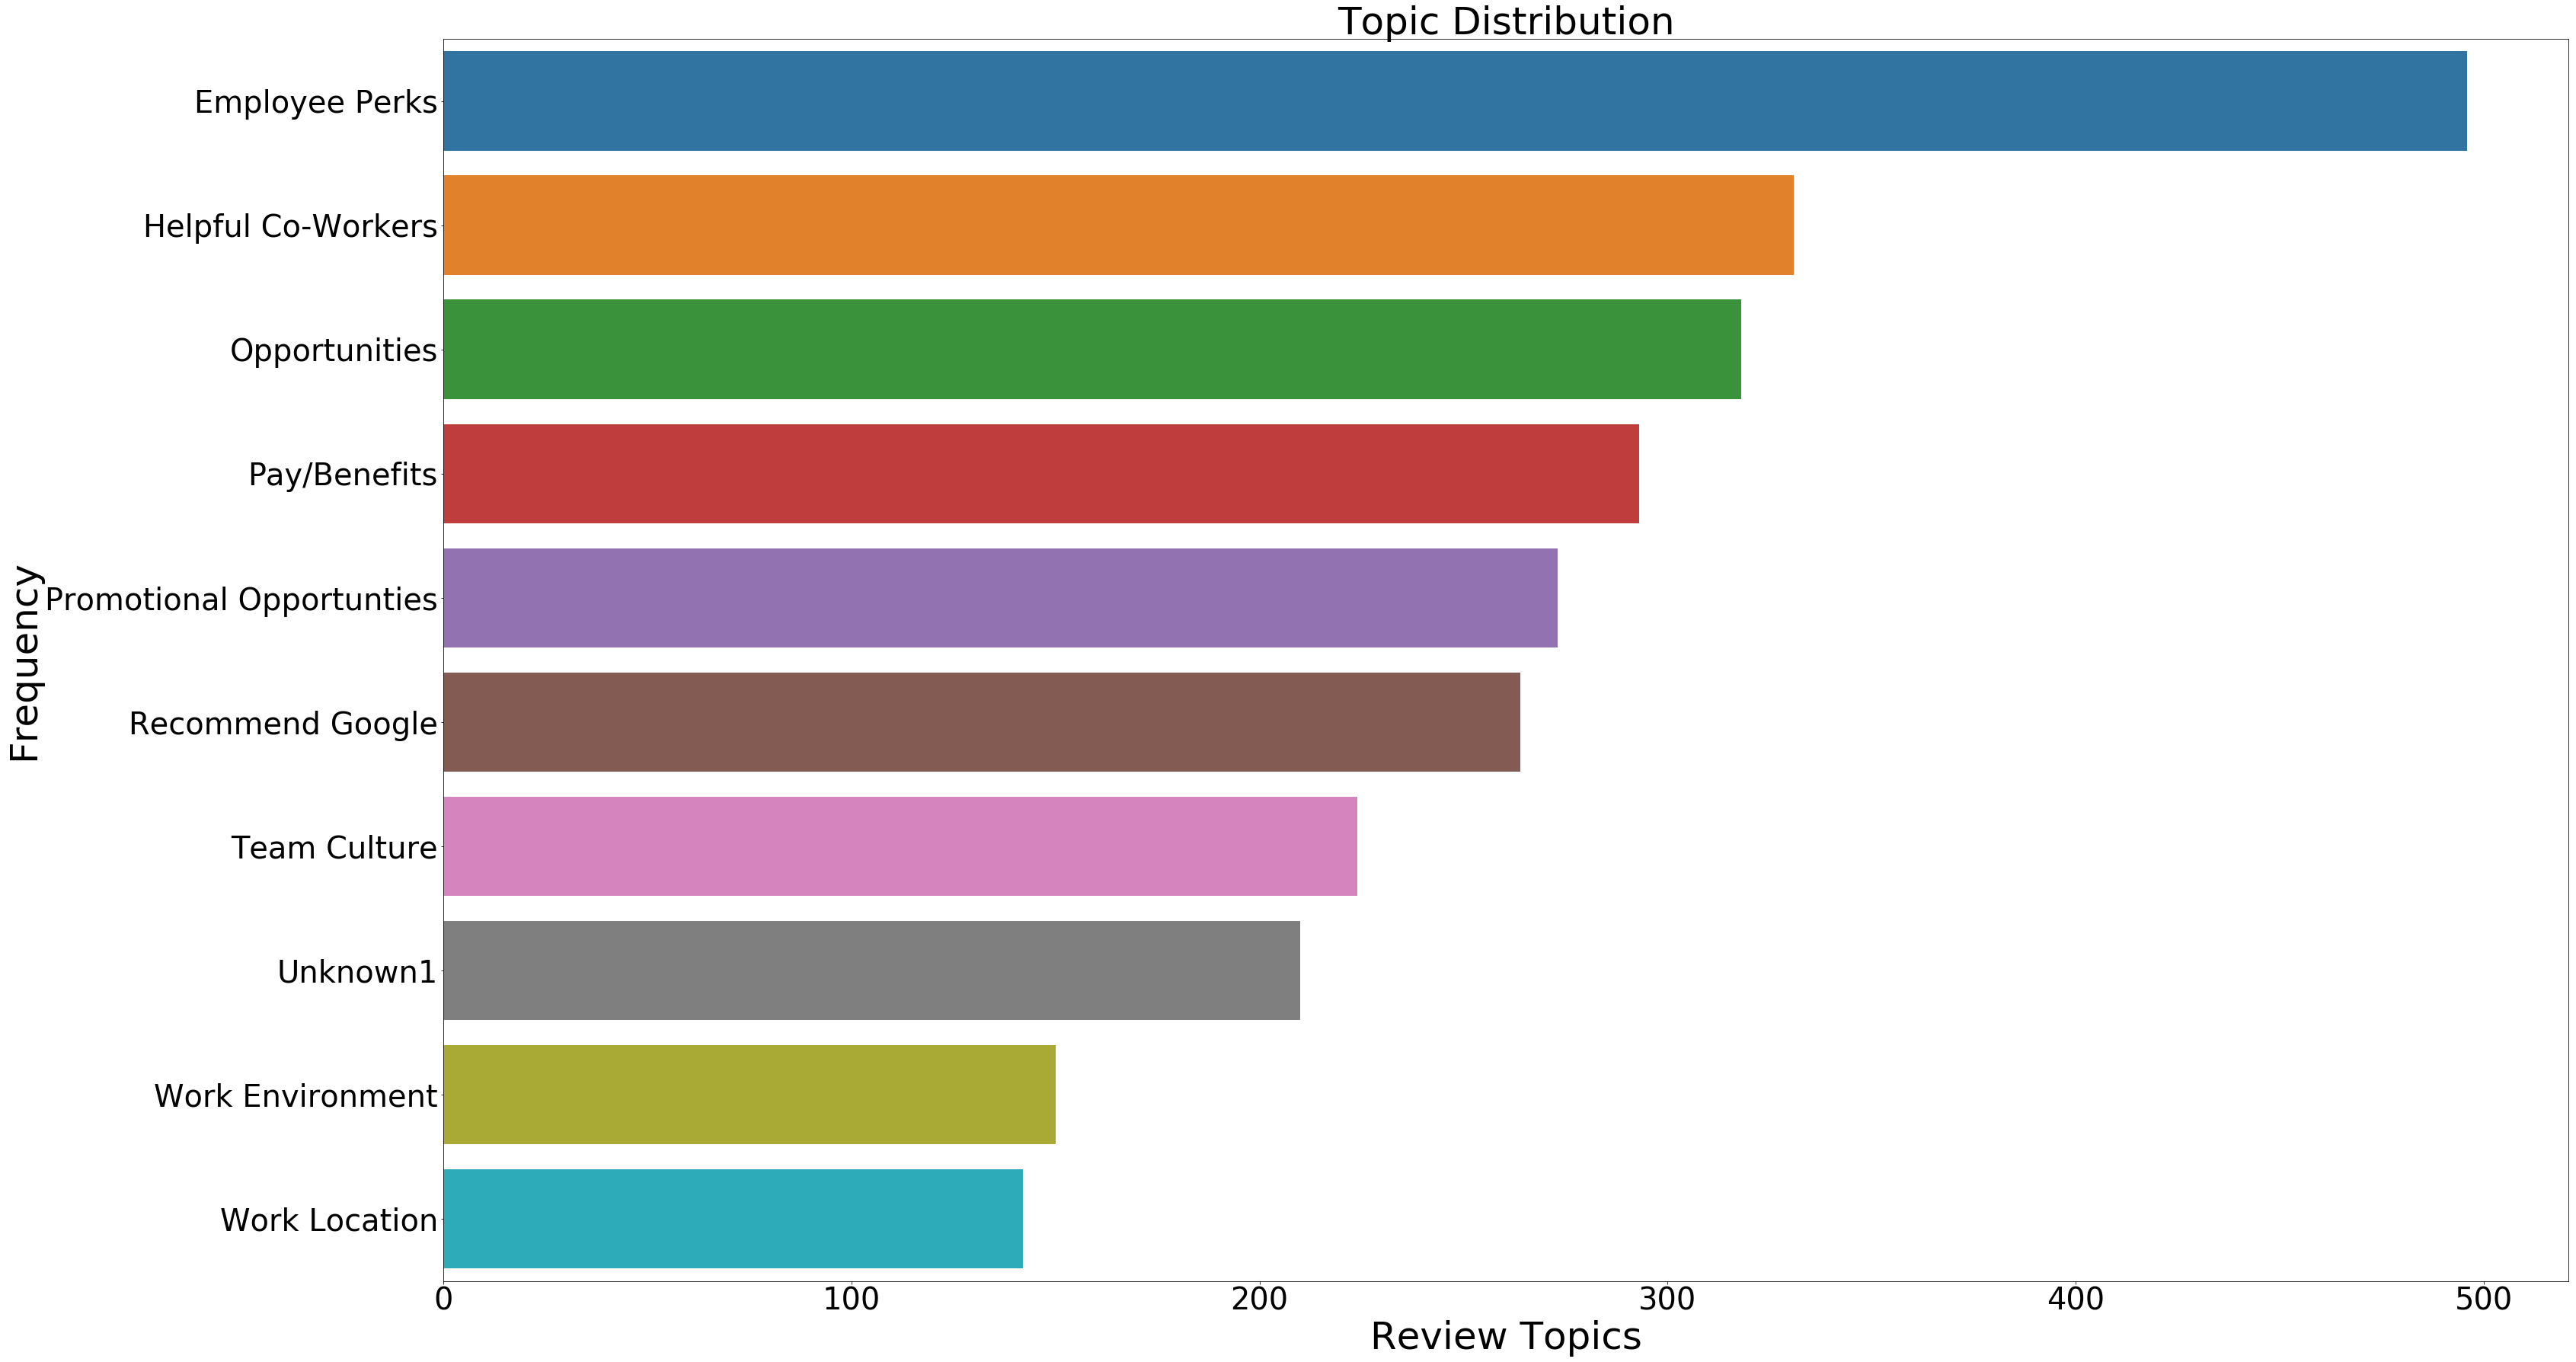

In [55]:
nmf_high_x = df_high_ratings.nmf_topics.value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("Topic Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

In [56]:
df.describe()

,rating,sentiment,review_len,word_count
count,3122.000000,3122.000000,3122.000000,3122.000000
mean,4.344651,0.342460,198.263613,19.567905
std,0.900204,0.259869,185.399493,18.397948
min,1.000000,-0.800000,31.000000,3.000000
25%,4.000000,0.166667,116.000000,12.000000
50%,5.000000,0.368750,134.000000,14.000000
75%,5.000000,0.511111,201.000000,19.000000
max,5.000000,1.000000,1330.000000,135.000000
